# Code for ROPM and RDPM Calculations
1. [Load and Process Data](#data)
2. [Ball Carrier Trajectories](#trajectories)
3. [Player Exposures](#exposures)
4. [Regression and Results](#regression)
5. [Example Play: WAS vs IND](#example)

## 1. Load and Process Data <a class="anchor" id="data"></a>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
###
import numpy as np
import pandas as pd
import glob
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import plotly.graph_objects as go
import pickle
import os
from sklearn import linear_model
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score

In [3]:
# Load data
games_df = pd.read_csv('/home/ryanl/Projects/nfl_big_data_bowl_2024/data/games.csv').set_index(['gameId']).sort_index(level=[0],ascending=[True])
plays_df = pd.read_csv('/home/ryanl/Projects/nfl_big_data_bowl_2024/data/plays.csv').set_index(['gameId','playId']).sort_index(level=[0,1],ascending=[True,True])
players_df = pd.read_csv('/home/ryanl/Projects/nfl_big_data_bowl_2024/data/players.csv').set_index(['nflId']).sort_index(level=[0],ascending=[True])
tackles_df = pd.read_csv('/home/ryanl/Projects/nfl_big_data_bowl_2024/data/tackles.csv').set_index(['gameId','playId','nflId']).sort_index(level=[0,1,2],ascending=[True,True,True])

glob.glob('/home/ryanl/Projects/nfl_big_data_bowl_2024/data/tracking_week_*.csv')

tracking_df = []
for f in glob.glob('/home/ryanl/Projects/nfl_big_data_bowl_2024/data/tracking_week_*.csv'):
    tracking_df += [pd.read_csv(f)]

tracking_df = pd.concat(tracking_df, axis=0).set_index(['gameId','playId','frameId']).sort_index(level=[0,1,2],ascending=[True,True,True])

In [4]:
print(len(games_df))
games_df.head()

136


,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
gameId,,,,,,,,
2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [5]:
print(len(plays_df))
plays_df.head()

12486


ballCarrierId ballCarrierDisplayName  \
gameId     playId                                         
2022090800 56              42489           Stefon Diggs   
           80              46076             Josh Allen   
           101             47857       Devin Singletary   
           122             47857       Devin Singletary   
           146             47857       Devin Singletary   

                                                     playDescription  quarter  \
gameId     playId                                                               
2022090800 56      (15:00) (Shotgun) J.Allen pass short right to ...        1   
           80      (14:29) (No Huddle, Shotgun) J.Allen scrambles...        1   
           101     (13:54) D.Singletary right end to BUF 45 for 7...        1   
           122     (13:15) (Shotgun) J.Allen pass short right to ...        1   
           146     (12:33) (Shotgun) D.Singletary left tackle to ...        1   

                   down  yardsToGo possessionTeam defensiveTeam yardlineSide  \
gameId     playId                                                              
2022090800 56         1         10            BUF            LA          BUF   
           80         2          4            BUF            LA          BUF   
           101        1         10            BUF            LA          BUF   
           122        2          3            BUF            LA          BUF   
           146        1         10            BUF            LA           LA   

                   yardlineNumber  ... preSnapHomeTeamWinProbability  \
gameId     playId                  ...                                 
2022090800 56                  25  ...                      0.413347   
           80                  31  ...                      0.413316   
           101                 38  ...                      0.399819   
           122                 45  ...                      0.384969   
           146                 49  ...                      0.365938   

                   preSnapVisitorTeamWinProbability  \
gameId     playId                                     
2022090800 56                              0.586653   
           80                              0.586684   
           101                             0.600181   
           122                             0.615031   
           146                             0.634062   

                   homeTeamWinProbabilityAdded visitorTeamWinProbilityAdded  \
gameId     playId                                                             
2022090800 56                        -0.000031                     0.000031   
           80                        -0.013497                     0.013497   
           101                       -0.014850                     0.014850   
           122                       -0.019032                     0.019032   
           146                        0.021616                    -0.021616   

                   expectedPoints  expectedPointsAdded  foulName1  foulName2  \
gameId     playId                                                              
2022090800 56            1.298699             0.004420        NaN        NaN   
           80            1.303119             0.823571        NaN        NaN   
           101           2.126690             0.562363        NaN        NaN   
           122           2.689053             0.399209        NaN        NaN   
           146           3.088262            -0.514056        NaN        NaN   

                  foulNFLId1  foulNFLId2  
gameId     playId                         
2022090800 56            NaN         NaN  
           80            NaN         NaN  
           101           NaN         NaN  
           122           NaN         NaN  
           146           NaN         NaN  

[5 rows x 33 columns]

In [6]:
print(len(players_df))
players_df.head()

1683


,height,weight,birthDate,collegeName,position,displayName
nflId,,,,,,
25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [7]:
print(len(tackles_df))
tackles_df.head()

17426


tackle  assist  forcedFumble  pff_missedTackle
gameId     playId nflId                                                
2022090800 56     43294       1       0             0                 0
           80     53532       1       0             0                 0
           101    42816       1       0             0                 0
           122    38577       1       0             0                 0
           146    38577       0       1             0                 0

In [8]:
print(len(tracking_df))
print(set(tracking_df['event']))
tracking_df.head()

12187398
{'touchdown', 'autoevent_passforward', 'pass_shovel', 'shift', 'ball_snap', 'qb_sack', 'fumble_defense_recovered', 'first_contact', nan, 'tackle', 'penalty_flag', 'penalty_accepted', 'autoevent_passinterrupted', 'man_in_motion', 'lateral', 'pass_forward', 'pass_outcome_touchdown', 'handoff', 'run', 'pass_arrived', 'fumble_offense_recovered', 'pass_outcome_caught', 'qb_slide', 'fumble', 'snap_direct', 'autoevent_ballsnap', 'safety', 'line_set', 'out_of_bounds', 'play_action', 'run_pass_option'}


nflId     displayName  \
gameId     playId frameId                            
2022090800 56     1        35472.0  Rodger Saffold   
                  1        38577.0    Bobby Wagner   
                  1        41239.0    Aaron Donald   
                  1        42392.0     Mitch Morse   
                  1        42489.0    Stefon Diggs   

                                                 time  jerseyNumber club  \
gameId     playId frameId                                                  
2022090800 56     1        2022-09-08 20:24:05.200000          76.0  BUF   
                  1        2022-09-08 20:24:05.200000          45.0   LA   
                  1        2022-09-08 20:24:05.200000          99.0   LA   
                  1        2022-09-08 20:24:05.200000          60.0  BUF   
                  1        2022-09-08 20:24:05.200000          14.0  BUF   

                          playDirection      x      y     s     a   dis  \
gameId     playId frameId                                                 
2022090800 56     1                left  88.37  27.27  1.62  1.15  0.16   
                  1                left  78.25  27.53  1.24  3.81  0.11   
                  1                left  91.08  31.61  3.91  2.34  0.40   
                  1                left  88.25  28.74  0.67  1.97  0.07   
                  1                left  80.60  38.29  6.23  0.90  0.62   

                                o     dir event  
gameId     playId frameId                        
2022090800 56     1        231.74  147.90   NaN  
                  1          4.20  331.67   NaN  
                  1        168.33  132.02   NaN  
                  1        244.21   30.29   NaN  
                  1        140.05  189.38   NaN

In [9]:
# Downselect to designed run plays
plays_df = plays_df[ plays_df['passResult'].isna() ]

In [10]:
print(len(plays_df))
plays_df.head()

6381


ballCarrierId ballCarrierDisplayName  \
gameId     playId                                         
2022090800 101             47857       Devin Singletary   
           146             47857       Devin Singletary   
           191             52494              Zack Moss   
           299             47853      Darrell Henderson   
           343             47853      Darrell Henderson   

                                                     playDescription  quarter  \
gameId     playId                                                               
2022090800 101     (13:54) D.Singletary right end to BUF 45 for 7...        1   
           146     (12:33) (Shotgun) D.Singletary left tackle to ...        1   
           191     (11:20) Z.Moss right end to LA 34 for 1 yard (...        1   
           299     (9:52) D.Henderson up the middle to LA 22 for ...        1   
           343     (9:04) (Shotgun) D.Henderson up the middle to ...        1   

                   down  yardsToGo possessionTeam defensiveTeam yardlineSide  \
gameId     playId                                                              
2022090800 101        1         10            BUF            LA          BUF   
           146        1         10            BUF            LA           LA   
           191        1         10            BUF            LA           LA   
           299        1         10             LA           BUF           LA   
           343        2         10             LA           BUF           LA   

                   yardlineNumber  ... preSnapHomeTeamWinProbability  \
gameId     playId                  ...                                 
2022090800 101                 38  ...                      0.399819   
           146                 49  ...                      0.365938   
           191                 35  ...                      0.355684   
           299                 17  ...                      0.269681   
           343                 17  ...                      0.260003   

                   preSnapVisitorTeamWinProbability  \
gameId     playId                                     
2022090800 101                             0.600181   
           146                             0.634062   
           191                             0.644316   
           299                             0.730319   
           343                             0.739997   

                   homeTeamWinProbabilityAdded visitorTeamWinProbilityAdded  \
gameId     playId                                                             
2022090800 101                       -0.014850                     0.014850   
           146                        0.021616                    -0.021616   
           191                        0.004001                    -0.004001   
           299                        0.000072                    -0.000072   
           343                       -0.008113                     0.008113   

                   expectedPoints  expectedPointsAdded  foulName1  foulName2  \
gameId     playId                                                              
2022090800 101           2.126690             0.562363        NaN        NaN   
           146           3.088262            -0.514056        NaN        NaN   
           191           3.947647            -0.413325        NaN        NaN   
           299           0.723416            -0.105841        NaN        NaN   
           343           0.070933            -0.737179        NaN        NaN   

                  foulNFLId1  foulNFLId2  
gameId     playId                         
2022090800 101           NaN         NaN  
           146           NaN         NaN  
           191           NaN         NaN  
           299           NaN         NaN  
           343           NaN         NaN  

[5 rows x 33 columns]

## 2. Ball Carrier Trajectories <a class="anchor" id="trajectories"></a>

In [11]:
###
def CalculateBCPathFromHandoff(plays, tracking):
    """
    """    
    #Get data
    gameIds = plays.index.get_level_values(0).values
    playIds = plays.index.get_level_values(1).values
    ballCarriers = plays['ballCarrierId'].values
    playResults = plays['prePenaltyPlayResult'].values
    penalties = plays['playNullifiedByPenalty'].values
    
    results_dic = {}
    results_dic['gameId'] = []
    results_dic['playId'] = []
    results_dic['frameId'] = []
    results_dic['x'] = []
    results_dic['y'] = []
    results_dic['isTackled'] = []
    results_dic['timeFromSnap'] = []
    results_dic['timeFromHandoff'] = []
    results_dic['playResult'] = []

    #Loop over plays
    for i,(gameId,playId) in enumerate(zip(gameIds,playIds)):

        #print(i+1,len(gameIds))

        # Check for penalty
        if penalties[i] == 'Y':
            continue
        
        #Get tracking data for this play
        df = tracking.loc[ (gameId, playId) ]
        
        #Find frames where snap, handoff, and tackle occur
        tmp_frames = (df['event'].groupby('frameId',group_keys=False).apply(lambda x: [ i for i in set(x) if isinstance(i,str) ]))
        tmp_frames = tmp_frames[ tmp_frames.str.len() > 0 ]
        
        snap_iframe = [ x for x,y in tmp_frames.items() if ( ('ball_snap' in y) or ('snap_direct' in y) ) ]
        handoff_iframe = [ x for x,y in tmp_frames.items() if ( ('handoff' in y) or ('run' in y) ) ]
        tackle_iframe = [ x for x,y in tmp_frames.items() if ( ('tackle' in y) or ('out_of_bounds' in y) or ('fumble' in y) or ('qb_slide' in y) or ('touchdown' in y) ) ]
        
        if (len(snap_iframe) == 0) or (len(handoff_iframe) == 0) or (len(tackle_iframe) == 0):
            # No snap or handoff or tackle, so ignore to filter out this play
            continue
        else:
            snap_iframe = snap_iframe[-1]
            handoff_iframe = handoff_iframe[-1]
            tackle_iframe = tackle_iframe[-1]

            if (tackle_iframe < snap_iframe) or (tackle_iframe < handoff_iframe) or (handoff_iframe < snap_iframe):
                continue

        # Get snap information
        if (np.sum(df.index.get_level_values(0) == snap_iframe) != 23) or (np.sum(df.index.get_level_values(0) == handoff_iframe) != 23) or (np.sum(df.index.get_level_values(0) == tackle_iframe) != 23):
            #Missing some tracking info, so skip
            continue

        snap_df = df.loc[ (snap_iframe) ]
        snap_df = snap_df[ snap_df['club'] == 'football' ]
        
        snap_x = snap_df['x'].values[-1]
        snap_y = snap_df['y'].values[-1]
        
        # Get ballcarier path
        bc_df = df[ (df['nflId'] == ballCarriers[i]) & (df.index.get_level_values(0) >= snap_iframe) & (df.index.get_level_values(0) <= tackle_iframe) ]

        if len(bc_df) == 0:
            display(tmp_frames)
            raise ValueError
        
        bc_xs = bc_df['x'].values
        bc_ys = bc_df['y'].values
        bc_zs = bc_df.index.get_level_values(0).values
        bc_directions = bc_df['playDirection'].values
        
        for x,y,z,direction in zip(bc_xs, bc_ys, bc_zs, bc_directions):
            if (z >= handoff_iframe) and (z <= tackle_iframe):
                results_dic['gameId'] += [ gameId ]
                results_dic['playId'] += [ playId ]
                results_dic['x'] += [ (x - snap_x) if (direction == 'right') else (snap_x - x) ]
                results_dic['y'] += [ (snap_y - y) if (direction == 'right') else (y - snap_y) ]
                results_dic['frameId'] += [ z ]
                results_dic['isTackled'] += [ z == tackle_iframe ]
                results_dic['timeFromSnap'] += [ (z - snap_iframe)*0.1 ]
                results_dic['timeFromHandoff'] += [ (z - handoff_iframe)*0.1 ]
                results_dic['playResult'] += [ playResults[i] ]

    #Return result
    return pd.DataFrame(results_dic)

In [12]:
# Initialize ball carrier path df
bc_df = CalculateBCPathFromHandoff(plays_df, tracking_df)

In [13]:
bc_df.head()

,gameId,playId,frameId,x,y,isTackled,timeFromSnap,timeFromHandoff,playResult
0,2022090800,101,19,-7.119999,2.51,False,1.3,0.0,7
1,2022090800,101,20,-6.969999,2.99,False,1.4,0.1,7
2,2022090800,101,21,-6.779999,3.49,False,1.5,0.2,7
3,2022090800,101,22,-6.559999,4.01,False,1.6,0.3,7
4,2022090800,101,23,-6.299999,4.53,False,1.7,0.4,7


In [14]:
# Pivot out timesteps
em_df = bc_df[ (bc_df['timeFromHandoff'] < 1.) ][['gameId','playId','timeFromHandoff','x','y']]
em_df = em_df.set_index(['gameId','playId']).sort_index(level=[0,1],ascending=[True,True])
em_df = em_df.pivot(columns='timeFromHandoff',values=['x','y'])
em_df = em_df.dropna()

In [15]:
em_df

x                                                    \
timeFromHandoff         0.0       0.1       0.2       0.3       0.4       0.5   
gameId     playId                                                               
2022090800 101    -7.119999 -6.969999 -6.779999 -6.559999 -6.299999 -5.999999   
           146    -1.340000 -1.140000 -0.950000 -0.760000 -0.580000 -0.410000   
           191    -6.749999 -6.639999 -6.499999 -6.339999 -6.159999 -5.949999   
           299    -5.120001 -4.730001 -4.320001 -3.880001 -3.410001 -2.920001   
           343    -5.020001 -4.750001 -4.450001 -4.110001 -3.740001 -3.360001   
...                     ...       ...       ...       ...       ...       ...   
2022110700 3658   -6.190002 -6.000002 -5.810002 -5.620002 -5.420002 -5.240002   
           3686   -4.920000 -4.570000 -4.180000 -3.770000 -3.350000 -2.910000   
           3707   -4.769999 -4.419999 -4.069999 -3.739999 -3.429999 -3.149999   
           3740   -6.920000 -6.900000 -6.890000 -6.870000 -6.850000 -6.820000   
           3787   -3.939999 -3.669999 -3.359999 -3.019999 -2.649999 -2.259999   

                                                                  y            \
timeFromHandoff         0.6       0.7       0.8       0.9       0.0       0.1   
gameId     playId                                                               
2022090800 101    -5.659999 -5.289999 -4.879999 -4.439999  2.510000  2.990000   
           146    -0.240000 -0.070000  0.110000  0.310000  0.549999  0.199999   
           191    -5.709999 -5.459999 -5.189999 -4.909999  2.850001  3.350001   
           299    -2.420001 -1.900001 -1.360001 -0.800001 -2.100000 -2.420000   
           343    -2.970001 -2.580001 -2.190001 -1.810001  0.999999  0.729999   
...                     ...       ...       ...       ...       ...       ...   
2022110700 3658   -5.060002 -4.870002 -4.670002 -4.470002 -2.229999 -2.709999   
           3686   -2.450000 -2.000000 -1.540000 -1.090000  0.880000  1.010000   
           3707   -2.909999 -2.709999 -2.529999 -2.359999 -0.150000 -0.040000   
           3740   -6.790000 -6.750000 -6.700000 -6.640000 -3.330001 -3.930001   
           3787   -1.839999 -1.389999 -0.929999 -0.449999 -0.910000 -0.570000   

                                                                               \
timeFromHandoff         0.2       0.3       0.4       0.5       0.6       0.7   
gameId     playId                                                               
2022090800 101     3.490000  4.010000  4.530000  5.070000  5.610000  6.160000   
           146    -0.190001 -0.620001 -1.060001 -1.520001 -2.000001 -2.480001   
           191     3.890001  4.450001  5.030001  5.610001  6.230001  6.850001   
           299    -2.730000 -3.020000 -3.270000 -3.470000 -3.630000 -3.750000   
           343     0.449999  0.189999 -0.060001 -0.280001 -0.460001 -0.590001   
...                     ...       ...       ...       ...       ...       ...   
2022110700 3658   -3.199999 -3.719999 -4.249999 -4.779999 -5.299999 -5.799999   
           3686    1.150000  1.320000  1.510000  1.730000  1.960000  2.210000   
           3707    0.110000  0.310000  0.550000  0.850000  1.200000  1.590000   
           3740   -4.550001 -5.200001 -5.880001 -6.580001 -7.290001 -8.010001   
           3787   -0.210000  0.140000  0.480000  0.810000  1.080000  1.320000   

                                       
timeFromHandoff         0.8       0.9  
gameId     playId                      
2022090800 101     6.710000  7.260000  
           146    -2.970001 -3.440001  
           191     7.490001  8.160001  
           299    -3.840000 -3.890000  
           343    -0.670001 -0.700001  
...                     ...       ...  
2022110700 3658   -6.259999 -6.669999  
           3686    2.490000  2.780000  
           3707    2.030000  2.490000  
           3740   -8.730001 -9.450001  
           3787    1.520000  1.680000  

[6169 rows x 20 columns]

In [16]:
# Run EM algorithm to find GMM for rushing classes
#-
nums = []
bics = []

for i in range(3,15):
    rt_gm = GaussianMixture(n_components=i, random_state=0).fit(em_df.values)
    nums += [i]
    bics += [rt_gm.bic(em_df.values)]
    print(nums[-1], bics[-1])

print()

#-
arg = np.argmin(bics)
rt_gm = GaussianMixture(n_components=nums[arg], random_state=0).fit(em_df.values)

print(nums[arg], bics[arg])

3 -497336.8689297524
4 -501056.0470894284
5 -502322.4746715006
6 -504335.6735967451
7 -505225.54576147185
8 -504189.3683278818
9 -503533.85704716516
10 -502444.7729028225
11 -501758.5948976957
12 -500765.67632280174
13 -500242.9885353584
14 -499972.40811135335

7 -505225.54576147185


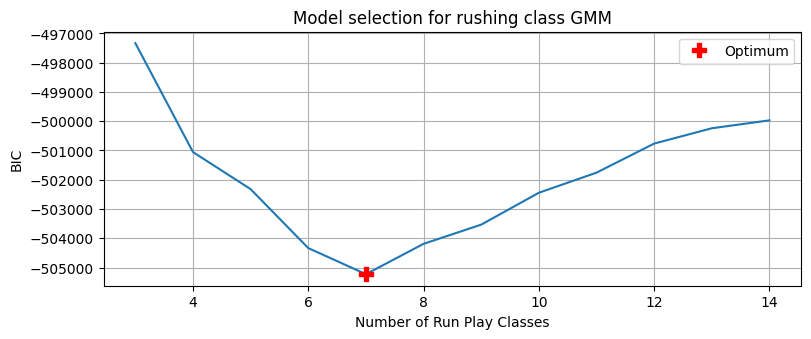

In [17]:
# Plot model selection results
plt.figure(figsize=(9,3.3))

plt.plot(nums,bics)
plt.plot(nums[4],bics[4],'rP',markersize=10,label='Optimum')

plt.xlabel('Number of Run Play Classes')
plt.ylabel('BIC')

plt.grid(which='both')
plt.legend()

plt.title('Model selection for rushing class GMM')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/EM_BIC.png', bbox_inches='tight')

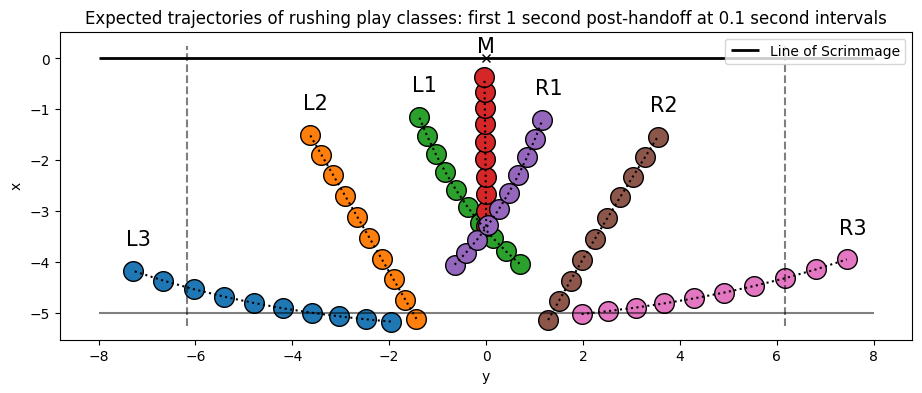

In [18]:
# Plot rushing classes
runtypes = {0:'L3',1:'R2',2:'L1',3:'L2',4:'R3',5:'R1',6:'M'}

plt.figure(figsize=(11,4))

plt.plot([0.], [0.], 'kx')
plt.hlines(0., -8, 8, 'k', linestyle='solid', alpha=1.0, linewidths=2, label='Line of Scrimmage')
plt.hlines(-5., -8, 8, 'k', linestyle='solid', alpha=0.5)
plt.vlines(-6.167, -5.25, 0.25, 'k', linestyle='dashed', alpha=0.5)
plt.vlines(6.167, -5.25, 0.25, 'k', linestyle='dashed', alpha=0.5)

for i in [0,3,2,6,5,1,4]:
    g = rt_gm.means_[i]
    plt.plot(g[10:], g[:10], 'k:')
    plt.scatter(g[10:], g[:10], s=200, edgecolors='k')
    plt.annotate(runtypes[i], (g[19]-0.15, g[9]+0.5), fontsize=15)

plt.xlabel('y')
plt.ylabel('x')

plt.legend()

plt.title('Expected trajectories of rushing play classes: first 1 second post-handoff at 0.1 second intervals')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/run_play_classes.png', bbox_inches='tight')

In [19]:
# Label each play with most likely rushing class
tmp = bc_df[bc_df['timeFromHandoff'] < 1.].set_index(['gameId','playId']).sort_index(level=[0,1],ascending=[True,True])[['timeFromHandoff','x','y']].pivot(columns='timeFromHandoff',values=['x','y'])
tmp = tmp.dropna()
tmp['runType'] = rt_gm.predict(tmp.values)
runType = tmp[['runType']]
runType.columns = runType.columns.droplevel(1)
runType

runType
gameId     playId         
2022090800 101           4
           146           0
           191           4
           299           3
           343           2
...                    ...
2022110700 3658          3
           3686          1
           3707          1
           3740          0
           3787          5

[6169 rows x 1 columns]

In [20]:
# Initialize df for calculating trajectory stats
avg_df = bc_df[['gameId','playId','timeFromHandoff','timeFromSnap','x','y','isTackled','playResult']]
avg_df = avg_df.set_index(['gameId','playId']).sort_index(level=[0,1],ascending=[True,True])
avg_df['runType'] = runType

avg_df

timeFromHandoff  timeFromSnap         x     y  isTackled  \
gameId     playId                                                             
2022090800 101                 0.0           1.3 -7.119999  2.51      False   
           101                 0.1           1.4 -6.969999  2.99      False   
           101                 0.2           1.5 -6.779999  3.49      False   
           101                 0.3           1.6 -6.559999  4.01      False   
           101                 0.4           1.7 -6.299999  4.53      False   
...                            ...           ...       ...   ...        ...   
2022110700 3787                2.1           3.0  4.740001  3.44      False   
           3787                2.2           3.1  5.020001  3.60      False   
           3787                2.3           3.2  5.270001  3.74      False   
           3787                2.4           3.3  5.450001  3.86      False   
           3787                2.5           3.4  5.610001  3.95       True   

                   playResult  runType  
gameId     playId                       
2022090800 101              7      4.0  
           101              7      4.0  
           101              7      4.0  
           101              7      4.0  
           101              7      4.0  
...                       ...      ...  
2022110700 3787             5      5.0  
           3787             5      5.0  
           3787             5      5.0  
           3787             5      5.0  
           3787             5      5.0  

[204497 rows x 7 columns]

In [21]:
# Find mean tackle coords for each rushing class
exp_coords = avg_df[ avg_df['isTackled'] == True ].groupby('runType').mean()

exp_coords

,timeFromHandoff,timeFromSnap,x,y,isTackled,playResult
runType,,,,,,
0.0,3.740449,5.104944,6.106022,-18.855798,1.0,5.943820
1.0,3.164878,4.521173,4.434142,7.153577,1.0,4.579399
2.0,3.232713,4.409956,4.974070,-3.620875,1.0,4.836980
3.0,3.121336,4.469650,4.483716,-7.318411,1.0,4.529183
4.0,3.710758,5.068460,5.914963,18.870367,1.0,5.704156
5.0,3.295729,4.513750,5.135792,2.585083,1.0,5.033333
6.0,2.564072,3.674651,1.813832,0.165489,1.0,1.958084


In [22]:
# Calculate mean coords and probability of ball carrier reaching for each time from snap
rc_df = avg_df.groupby(['runType','timeFromHandoff']).mean()
rc_df['count'] = avg_df.groupby(['runType','timeFromHandoff']).count()['x']
rc_df['prob'] = rc_df['count'] / rc_df['count'].groupby(['runType']).head(1).droplevel(1)

rc_df = rc_df[ rc_df['prob'] >= 0.05 ]

rc_df

timeFromSnap         x         y  isTackled  \
runType timeFromHandoff                                                
0.0     0.0                  1.364494 -5.182068 -1.989506   0.000000   
        0.1                  1.464494 -5.140045 -2.511933   0.000000   
        0.2                  1.564494 -5.085416 -3.060090   0.000000   
        0.3                  1.664494 -5.017528 -3.630315   0.000000   
        0.4                  1.764494 -4.933461 -4.219393   0.000000   
...                               ...       ...       ...        ...   
6.0     3.9                  4.930000  3.953500  0.463833   0.116667   
        4.0                  5.054717  4.335283  0.082264   0.188679   
        4.1                  5.197674  4.931396  0.504651   0.093023   
        4.2                  5.289744  5.249487  0.888974   0.179487   
        4.3                  5.418750  5.691563  2.025312   0.218750   

                         playResult  count      prob  
runType timeFromHandoff                               
0.0     0.0                5.943820    445  1.000000  
        0.1                5.943820    445  1.000000  
        0.2                5.943820    445  1.000000  
        0.3                5.943820    445  1.000000  
        0.4                5.943820    445  1.000000  
...                             ...    ...       ...  
6.0     3.9                6.050000     60  0.119760  
        4.0                6.603774     53  0.105788  
        4.1                7.651163     43  0.085828  
        4.2                8.153846     39  0.077844  
        4.3                8.750000     32  0.063872  

[383 rows x 7 columns]

4 1.0 0.051685393258426963
4 1.0 0.05007153075822604
4 1.0 0.05470459518599562
4 1.0 0.054474708171206226
4 1.0 0.05134474327628362
4 1.0 0.053125
4 1.0 0.06387225548902195


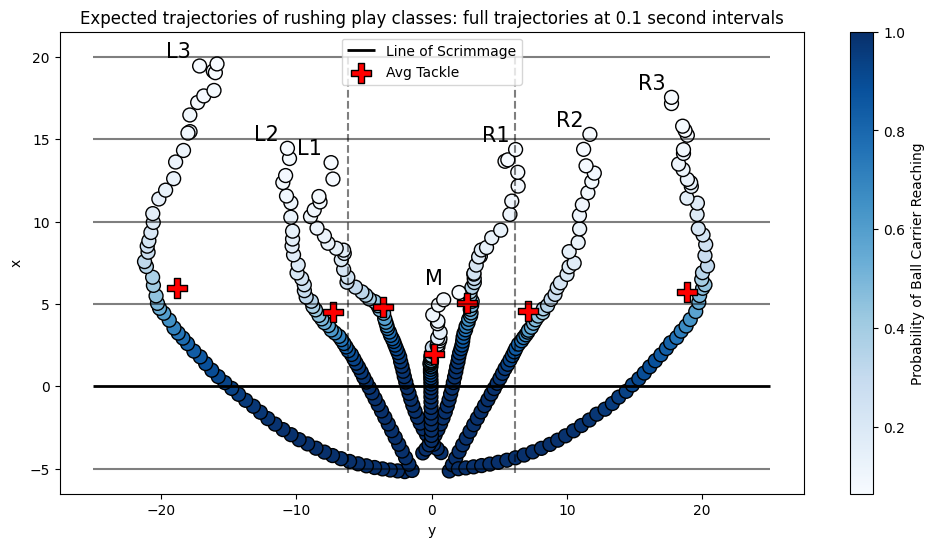

In [23]:
# Plot rushing class trajectory stats
plt.figure(figsize=(12,6))

plt.hlines(-5., -25, 25, 'k', linestyle='solid', alpha=0.5)
plt.hlines(0., -25, 25, 'k', linestyle='solid', alpha=1.0, linewidths=2, label='Line of Scrimmage')
plt.hlines(5., -25, 25, 'k', linestyle='solid', alpha=0.5)
plt.hlines(10., -25, 25, 'k', linestyle='solid', alpha=0.5)
plt.hlines(15., -25, 25, 'k', linestyle='solid', alpha=0.5)
plt.hlines(20., -25, 25, 'k', linestyle='solid', alpha=0.5)

plt.vlines(-6.167, -5.25, 20.25, 'k', linestyle='dashed', alpha=0.5)
plt.vlines(6.167, -5.25, 20.25, 'k', linestyle='dashed', alpha=0.5)

for key in runtypes:
    tmp = rc_df.loc[key]

    print(i, tmp['prob'].max(), tmp['prob'].min())

    plt.annotate(runtypes[key], (tmp['y'].values[-1]-2.5, tmp['x'].values[-1]+0.5), fontsize=15)
    plt.scatter(tmp['y'].values, tmp['x'].values, c=tmp['prob'].values, s=100, cmap='Blues', edgecolors='k')

cb = plt.colorbar()
cb.set_label('Probability of Ball Carrier Reaching')

plt.scatter(exp_coords['y'].values, exp_coords['playResult'].values, color='r', marker='P', s=200, edgecolors='k', label='Avg Tackle')

plt.xlabel('y')
plt.ylabel('x')

plt.legend(loc='upper center')

plt.title('Expected trajectories of rushing play classes: full trajectories at 0.1 second intervals')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/run_play_trajectories.png', bbox_inches='tight')

## 3. Player Exposures <a class="anchor" id="exposures"></a>

In [24]:
###
def CalculateDistanceSnapToExpectedBallCarrier(plays, tracking, runCoords):
    """
    """    
    #Get data
    gameIds = plays.index.get_level_values(0).values
    playIds = plays.index.get_level_values(1).values
    possessionTeams = plays['possessionTeam'].values
    defensiveTeams = plays['defensiveTeam'].values
    ballCarriers = plays['ballCarrierId'].values
    runTypes = plays['runType'].values
    yardsGaineds = plays['prePenaltyPlayResult'].values
    EPAs = plays['expectedPointsAdded'].values
    penalties = plays['playNullifiedByPenalty'].values
    
    results_dic = {}
    results_dic['gameId'] = []
    results_dic['playId'] = []
    results_dic['nflId'] = []
    results_dic['isBallCarrier'] = []
    results_dic['side'] = []
    results_dic['teamName'] = []
    results_dic['runType'] = []
    results_dic['yardsGained'] = []
    results_dic['EPA'] = []
    results_dic['speedsNeededToReach'] = []
    results_dic['weights'] = []
    results_dic['x'] = []
    results_dic['y'] = []

    #Loop over plays
    for i,(gameId,playId) in enumerate(zip(gameIds,playIds)):
        
        #print(i+1,len(gameIds))

        # Check for penalty
        if penalties[i] == 'Y':
            continue
        
        # Check for missing plays data
        if np.isnan(runTypes[i]) or np.isnan(yardsGaineds[i]) or np.isnan(EPAs[i]):
            continue
        
        #Get tracking data for this play
        df = tracking.loc[ (gameId, playId) ]
        
        #Find frames where snap and tackle occur
        tmp_frames = (df['event'].groupby('frameId',group_keys=False).apply(lambda x: [ i for i in set(x) if isinstance(i,str) ]))
        tmp_frames = tmp_frames[ tmp_frames.str.len() > 0 ]
        
        snap_iframe = [ x for x,y in tmp_frames.items() if ( ('ball_snap' in y) or ('snap_direct' in y) ) ]
        handoff_iframe = [ x for x,y in tmp_frames.items() if ( ('handoff' in y) or ('run' in y) ) ]
        tackle_iframe = [ x for x,y in tmp_frames.items() if ( ('tackle' in y) or ('out_of_bounds' in y) or ('fumble' in y) or ('qb_slide' in y) or ('touchdown' in y) ) ]
        
        if (len(snap_iframe) == 0) or (len(handoff_iframe) == 0) or (len(tackle_iframe) == 0):
            # No snap or handoff or tackle, so ignore to filter out this play
            continue
        else:
            snap_iframe = snap_iframe[-1]
            handoff_iframe = handoff_iframe[-1]
            tackle_iframe = tackle_iframe[-1]

            if (tackle_iframe < snap_iframe) or (tackle_iframe < handoff_iframe) or (handoff_iframe < snap_iframe):
                continue

        # Get snap and handoff information
        if (np.sum(df.index.get_level_values(0) == snap_iframe) != 23) or (np.sum(df.index.get_level_values(0) == handoff_iframe) != 23) or (np.sum(df.index.get_level_values(0) == tackle_iframe) != 23):
            #Missing some tracking info, so skip
            continue
        
        #Calculate distances from players' snap positions to expected ball carrier for each frame between snap and tackle
        df = df.loc[ snap_iframe ]
        bc_df = runCoords.loc[ runTypes[i] ]
        
        bc_xs = bc_df['x'].values
        bc_ys = bc_df['y'].values
        bc_ts = bc_df['timeFromSnap'].values
        bc_ws = bc_df['prob'].values

        snap_df = df[ df['club'] == 'football' ]        
        snap_x = snap_df['x'].values[-1]
        snap_y = snap_df['y'].values[-1]
        
        for x,y,player,club,direction in zip(df['x'].values, df['y'].values, df['nflId'].values, df['club'].values, df['playDirection'].values):
            if ~np.isnan(player):
                results_dic['gameId'] += [ gameId ]
                results_dic['playId'] += [ playId ]
                results_dic['nflId'] += [ player ]
                results_dic['isBallCarrier'] += [ player == ballCarriers[i] ]
                results_dic['side'] += [ 'O' if (club == possessionTeams[i]) else 'D' if (club == defensiveTeams[i]) else 'B' ]
                results_dic['teamName'] += [ possessionTeams[i] if (club == possessionTeams[i]) else defensiveTeams[i] if (club == defensiveTeams[i]) else 'B' ]
                results_dic['runType'] += [ runTypes[i] ]
                results_dic['yardsGained'] += [ yardsGaineds[i] ]
                results_dic['EPA'] += [ EPAs[i] ]
                
                if direction == 'right':
                    distances = np.array([ np.sqrt( (x-snap_x-bc_x)**2 + (snap_y-y-bc_y)**2 ) for bc_x,bc_y in zip(bc_xs,bc_ys) ])
                else:
                    distances = np.array([ np.sqrt( (snap_x-x-bc_x)**2 + (y-snap_y-bc_y)**2 ) for bc_x,bc_y in zip(bc_xs,bc_ys) ])
                
                times = np.array([ bc_t for bc_t in bc_ts ])
                weights = np.array([ bc_w for bc_w in bc_ws ])
                
                results_dic['speedsNeededToReach'] += [ distances / times ]
                results_dic['weights'] += [ weights ]

                results_dic['x'] += [ (x - snap_x) if (direction == 'right') else (snap_x - x) ]
                results_dic['y'] += [ (snap_y - y) if (direction == 'right') else (y - snap_y) ]
    
    #Return result
    return pd.DataFrame(results_dic)

In [25]:
# Dictionary for cleaning up position labels
position_conversion_dic = {}
position_conversion_dic['C'] = 'OC'
position_conversion_dic['CB'] = 'CB'
position_conversion_dic['DB'] = 'S'
position_conversion_dic['DE'] = 'DE'
position_conversion_dic['DT'] = 'DT'
position_conversion_dic['FB'] = 'TE'
position_conversion_dic['FS'] = 'S'
position_conversion_dic['G'] = 'OG'
position_conversion_dic['ILB'] = 'ILB'
position_conversion_dic['LS'] = 'LS'
position_conversion_dic['MLB'] = 'ILB'
position_conversion_dic['NT'] = 'DT'
position_conversion_dic['OLB'] = 'OLB'
position_conversion_dic['QB'] = 'QB'
position_conversion_dic['RB'] = 'RB'
position_conversion_dic['SS'] = 'S'
position_conversion_dic['T'] = 'OT'
position_conversion_dic['TE'] = 'TE'
position_conversion_dic['WR'] = 'WR'

In [26]:
# Add rushing class labels to plays_df
plays_df['runType'] = runType

plays_df.head()

ballCarrierId ballCarrierDisplayName  \
gameId     playId                                         
2022090800 101             47857       Devin Singletary   
           146             47857       Devin Singletary   
           191             52494              Zack Moss   
           299             47853      Darrell Henderson   
           343             47853      Darrell Henderson   

                                                     playDescription  quarter  \
gameId     playId                                                               
2022090800 101     (13:54) D.Singletary right end to BUF 45 for 7...        1   
           146     (12:33) (Shotgun) D.Singletary left tackle to ...        1   
           191     (11:20) Z.Moss right end to LA 34 for 1 yard (...        1   
           299     (9:52) D.Henderson up the middle to LA 22 for ...        1   
           343     (9:04) (Shotgun) D.Henderson up the middle to ...        1   

                   down  yardsToGo possessionTeam defensiveTeam yardlineSide  \
gameId     playId                                                              
2022090800 101        1         10            BUF            LA          BUF   
           146        1         10            BUF            LA           LA   
           191        1         10            BUF            LA           LA   
           299        1         10             LA           BUF           LA   
           343        2         10             LA           BUF           LA   

                   yardlineNumber  ... preSnapVisitorTeamWinProbability  \
gameId     playId                  ...                                    
2022090800 101                 38  ...                         0.600181   
           146                 49  ...                         0.634062   
           191                 35  ...                         0.644316   
           299                 17  ...                         0.730319   
           343                 17  ...                         0.739997   

                   homeTeamWinProbabilityAdded  visitorTeamWinProbilityAdded  \
gameId     playId                                                              
2022090800 101                       -0.014850                      0.014850   
           146                        0.021616                     -0.021616   
           191                        0.004001                     -0.004001   
           299                        0.000072                     -0.000072   
           343                       -0.008113                      0.008113   

                  expectedPoints  expectedPointsAdded  foulName1  foulName2  \
gameId     playId                                                             
2022090800 101          2.126690             0.562363        NaN        NaN   
           146          3.088262            -0.514056        NaN        NaN   
           191          3.947647            -0.413325        NaN        NaN   
           299          0.723416            -0.105841        NaN        NaN   
           343          0.070933            -0.737179        NaN        NaN   

                   foulNFLId1 foulNFLId2  runType  
gameId     playId                                  
2022090800 101            NaN        NaN      4.0  
           146            NaN        NaN      0.0  
           191            NaN        NaN      4.0  
           299            NaN        NaN      3.0  
           343            NaN        NaN      2.0  

[5 rows x 34 columns]

In [27]:
# Initialize df for calculating player exposures
fit_df = CalculateDistanceSnapToExpectedBallCarrier(plays_df, tracking_df, rc_df)

In [28]:
# Add player positions
fit_df = fit_df.set_index(['nflId']).sort_index(level=[0],ascending=[True]).join(players_df[['position','displayName']])
fit_df['position'] = fit_df['position'].apply(lambda x: position_conversion_dic[x])

# Add player max speeds
max_speeds = tracking_df.groupby(['gameId','playId','nflId'])['s'].max().groupby('nflId').quantile(0.99)
max_speeds.name = 'maxSpeed'
fit_df = fit_df.join(max_speeds)

fit_df = fit_df.reset_index().set_index(['position']).sort_index(level=[0],ascending=[True])
#fit_df['maxSpeed'] = fit_df['maxSpeed'].groupby('position').mean() # Can use this to try per-position max speed
fit_df['maxSpeed'] = fit_df['maxSpeed'].mean() # This uses global max speed

fit_df = fit_df.reset_index()

In [29]:
# Calculate exposures using several different max-speed thresholds (as fraction of calculated max speed)
fit_df = fit_df.set_index(['gameId','playId']).sort_index(level=[0,1],ascending=[True,True])

fit_df['exposure1d00'] = [ np.sum((a <= (1.*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d75'] = [ np.sum((a <= (0.75*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d67'] = [ np.sum((a <= (0.67*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d50'] = [ np.sum((a <= (0.5*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d40'] = [ np.sum((a <= (0.4*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d33'] = [ np.sum((a <= (0.33*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d25'] = [ np.sum((a <= (0.25*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]
fit_df['exposure0d01'] = [ np.sum((a <= (0.01*b))*w) / np.sum(w) for a,b,w in zip(fit_df['speedsNeededToReach'].values,fit_df['maxSpeed'].values,fit_df['weights'].values) ]

fit_df = fit_df.reset_index()

In [30]:
# Add per-team EPA aggs
fit_df = fit_df.set_index(['teamName','side']).sort_index(level=[0,1],ascending=[True,True])

fit_df['teamEPA'] = fit_df['EPA'].groupby(['teamName','side']).mean()
fit_df.loc[fit_df.index.get_level_values(1) == 'D', 'teamEPA'] *= -1

fit_df = fit_df.reset_index()

In [31]:
fit_df.head()

,teamName,side,gameId,playId,position,nflId,isBallCarrier,runType,yardsGained,EPA,...,maxSpeed,exposure1d00,exposure0d75,exposure0d67,exposure0d50,exposure0d40,exposure0d33,exposure0d25,exposure0d01,teamEPA
0,ARI,D,2022091110,55,CB,47816.0,False,2.0,9,0.6363,...,7.852959,0.817656,0.635345,0.574796,0.315877,0.021845,0.000000,0.000000,0.0,0.071427
1,ARI,D,2022091110,55,CB,53565.0,False,2.0,9,0.6363,...,7.852959,0.787265,0.665702,0.605054,0.455395,0.342477,0.242627,0.133067,0.0,0.071427
2,ARI,D,2022091110,55,DE,47848.0,False,2.0,9,0.6363,...,7.852959,1.000000,1.000000,0.969609,0.848047,0.696093,0.450873,0.000000,0.0,0.071427
3,ARI,D,2022091110,55,DE,48032.0,False,2.0,9,0.6363,...,7.852959,1.000000,1.000000,1.000000,0.969609,0.908828,0.817656,0.591122,0.0,0.071427
4,ARI,D,2022091110,55,DT,52539.0,False,2.0,9,0.6363,...,7.852959,1.000000,1.000000,1.000000,0.939219,0.908828,0.878437,0.804023,0.0,0.071427


In [32]:
# Calculate mean exposures by positions
tmp = fit_df[['side','position','runType','exposure0d33']].groupby(['side','position','runType']).mean()

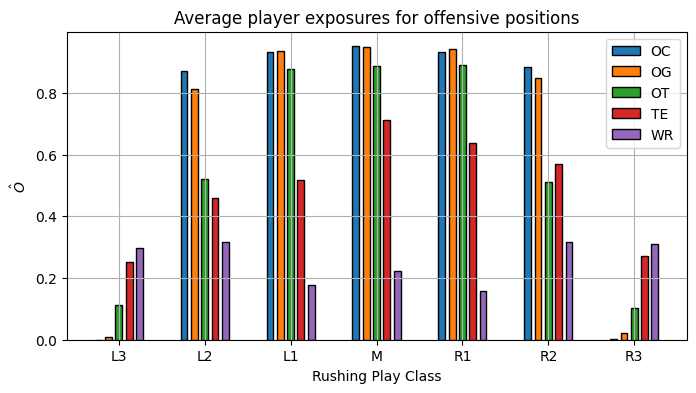

In [33]:
# Plot mean exposures for offensive positions
plt.figure(figsize=(8,4))

offset = [-0.24,-0.12,0.,0.12,0.24]
i = 0

for p in sorted(set(tmp.index.get_level_values(1))):
    zzz = tmp[ (tmp.index.get_level_values(0) == 'O') & (tmp.index.get_level_values(1) == p) & (~tmp.index.get_level_values(1).isin(['QB','RB','DT','ILB'])) ]
    if len(zzz) > 0:
        plt.bar(np.arange(0,7)+offset[i], zzz.droplevel([0,1]).loc[ [0.,3.,2.,6.,5.,1.,4.] ].values.T[0], width=0.08, edgecolor='k', label=p)
        i += 1

plt.xticks(ticks=np.arange(0,7), labels=['L3','L2','L1','M','R1','R2','R3'])

plt.xlabel('Rushing Play Class')
plt.ylabel('$\hat{O}$')

plt.grid(which='both')

plt.legend()

plt.title('Average player exposures for offensive positions')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/Ohat.png')

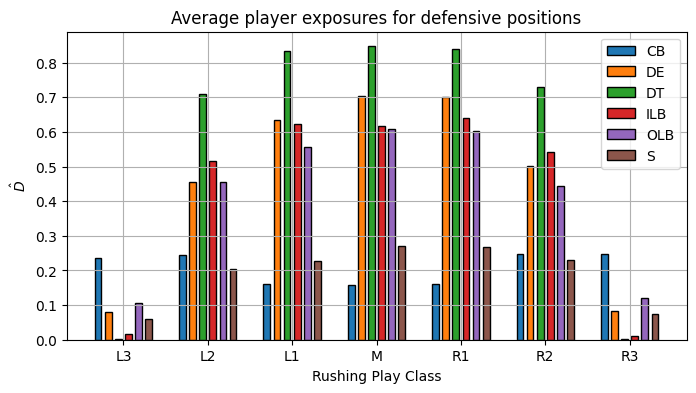

In [34]:
# Plot mean exposures for defensive positions
plt.figure(figsize=(8,4))

offset = [-0.30,-0.18,-0.06,0.06,0.18,0.30]
i = 0

for p in sorted(set(tmp.index.get_level_values(1))):
    zzz = tmp[ (tmp.index.get_level_values(0) == 'D') & (tmp.index.get_level_values(1) == p) ]
    if len(zzz) > 0:
        plt.bar(np.arange(0,7)+offset[i], zzz.droplevel([0,1]).loc[ [0.,3.,2.,6.,5.,1.,4.] ].values.T[0], width=0.08, edgecolor='k', label=p)
        i += 1

plt.xticks(ticks=np.arange(0,7), labels=['L3','L2','L1','M','R1','R2','R3'])

plt.xlabel('Rushing Play Class')
plt.ylabel('$\hat{D}$')

plt.grid(which='both')

plt.legend()

plt.title('Average player exposures for defensive positions')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/Dhat.png')

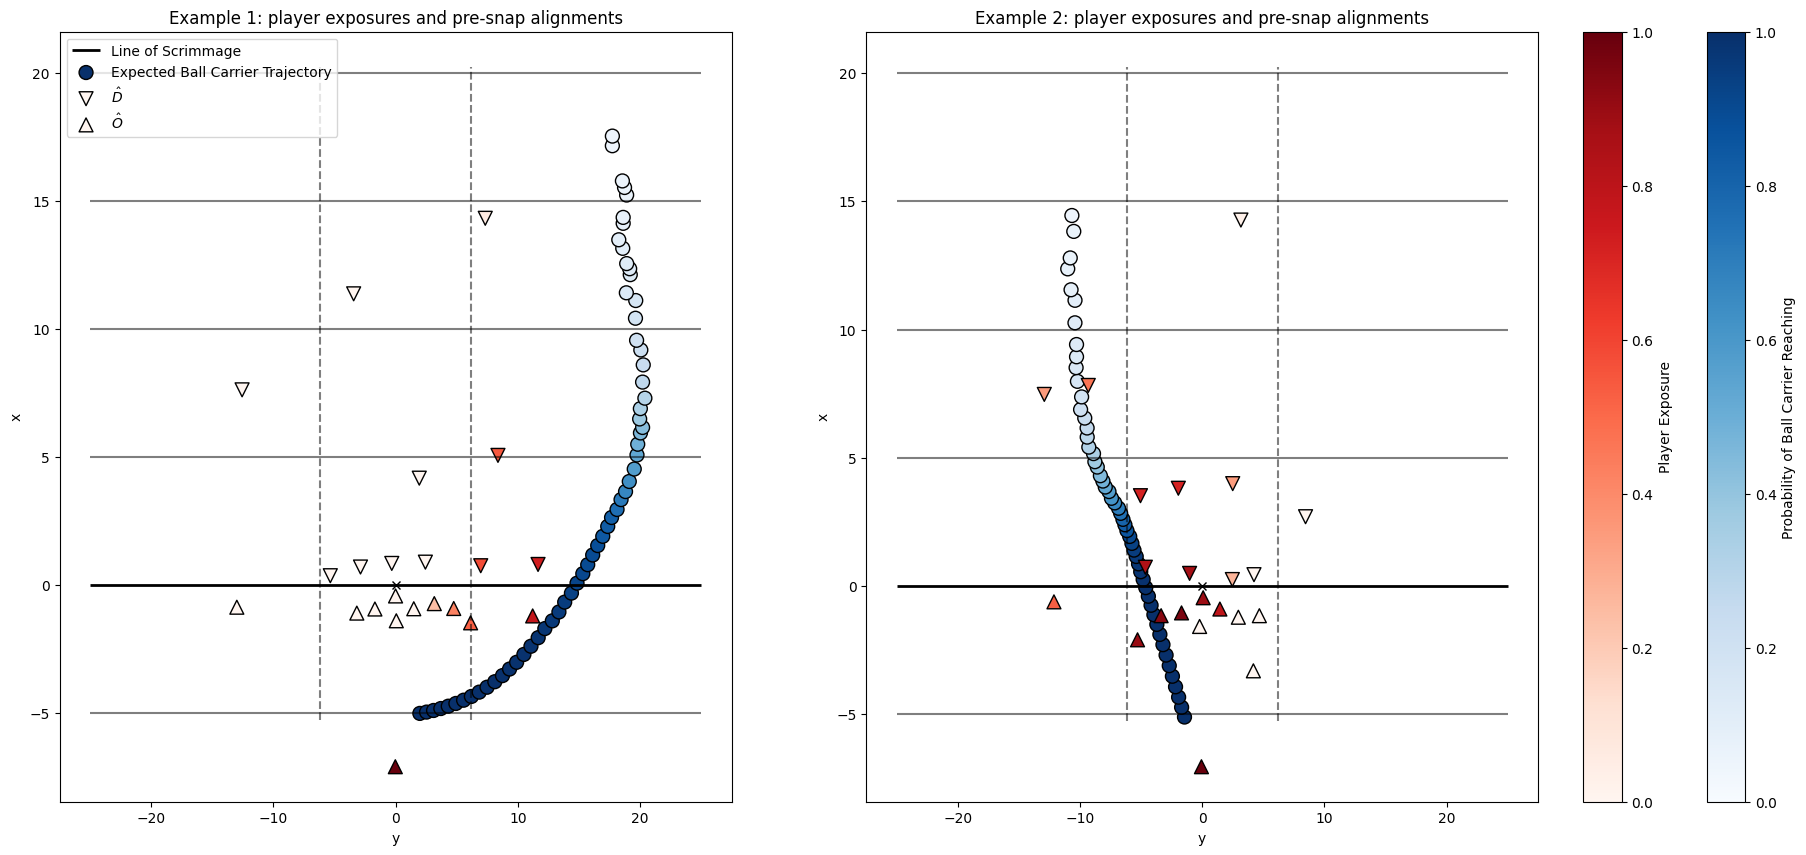

In [35]:
# Plot player exposures and pre-snap aligments for two example plays

### Common Plot ###
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(25, 10))

### Example 1 ###
###
eg_O = fit_df[ (fit_df['gameId'] == 2022090800) & (fit_df['playId'] == 191) & (fit_df['side'] == 'O') ]
eg_D = fit_df[ (fit_df['gameId'] == 2022090800) & (fit_df['playId'] == 191) & (fit_df['side'] == 'D') ]

eg_O.loc[ (eg_O['position'].isin(['QB','RB'])), 'exposure0d33' ] = 0.
eg_O.loc[ eg_O['isBallCarrier'], 'exposure0d33' ] = 1.

###

ax1.plot([0.], [0.], 'kx')

ax1.hlines(-5., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax1.hlines(0., -25, 25, 'k', linestyle='solid', alpha=1.0, linewidths=2, label='Line of Scrimmage')
ax1.hlines(5., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax1.hlines(10., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax1.hlines(15., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax1.hlines(20., -25, 25, 'k', linestyle='solid', alpha=0.5)

ax1.vlines(-6.167, -5.25, 20.25, 'k', linestyle='dashed', alpha=0.5)
ax1.vlines(6.167, -5.25, 20.25, 'k', linestyle='dashed', alpha=0.5)

for i in set(eg_O['runType']):
    tmp = rc_df.loc[i]
    ax1.scatter(tmp['y'].values, tmp['x'].values, c=tmp['prob'].values, s=100, cmap='Blues', edgecolors='k', vmin=0., vmax=1., label='Expected Ball Carrier Trajectory')

ax1.scatter(eg_D['y'], eg_D['x'], c=eg_D['exposure0d33'], marker='v', s=100, cmap='Reds', edgecolors='k', vmin=0., vmax=1., label='$\hat{D}$')
ax1.scatter(eg_O['y'], eg_O['x'], c=eg_O['exposure0d33'], marker='^', s=100, cmap='Reds', edgecolors='k', vmin=0., vmax=1., label='$\hat{O}$')

ax1.set_xlabel('y')
ax1.set_ylabel('x')

ax1.legend()

ax1.set_title('Example 1: player exposures and pre-snap alignments')

### Example 2 ###
###
eg_O = fit_df[ (fit_df['gameId'] == 2022090800) & (fit_df['playId'] == 299) & (fit_df['side'] == 'O') ]
eg_D = fit_df[ (fit_df['gameId'] == 2022090800) & (fit_df['playId'] == 299) & (fit_df['side'] == 'D') ]

eg_O.loc[ (eg_O['position'].isin(['QB','RB'])), 'exposure0d33' ] = 0.
eg_O.loc[ eg_O['isBallCarrier'], 'exposure0d33' ] = 1.

###
ax2.plot([0.], [0.], 'kx')

ax2.hlines(-5., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax2.hlines(0., -25, 25, 'k', linestyle='solid', alpha=1.0, linewidths=2, label='Line of Scrimmage')
ax2.hlines(5., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax2.hlines(10., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax2.hlines(15., -25, 25, 'k', linestyle='solid', alpha=0.5)
ax2.hlines(20., -25, 25, 'k', linestyle='solid', alpha=0.5)

ax2.vlines(-6.167, -5.25, 20.25, 'k', linestyle='dashed', alpha=0.5)
ax2.vlines(6.167, -5.25, 20.25, 'k', linestyle='dashed', alpha=0.5)

for i in set(eg_O['runType']):
    tmp = rc_df.loc[i]
    a = ax2.scatter(tmp['y'].values, tmp['x'].values, c=tmp['prob'].values, s=100, cmap='Blues', edgecolors='k', vmin=0., vmax=1., label='Expected Ball Carrier Trajectory')

b = ax2.scatter(eg_D['y'], eg_D['x'], c=eg_D['exposure0d33'], marker='v', s=100, cmap='Reds', edgecolors='k', vmin=0., vmax=1., label='$\hat{D}$')
b = ax2.scatter(eg_O['y'], eg_O['x'], c=eg_O['exposure0d33'], marker='^', s=100, cmap='Reds', edgecolors='k', vmin=0., vmax=1., label='$\hat{O}$')

ax2.set_xlabel('y')
ax2.set_ylabel('x')

ax2.set_title('Example 2: player exposures and pre-snap alignments')

### Common Plot ###

cb1 = fig.colorbar(a, ax=(ax1, ax2), orientation='vertical', pad=-0.075)
cb1.set_label('Probability of Ball Carrier Reaching')

cb2 = fig.colorbar(b, ax=(ax1, ax2), orientation='vertical', pad=0.025)
cb2.set_label('Player Exposure')

fig.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/example_exposures.png', bbox_inches='tight')

## 4. Regression and Results <a class="anchor" id="regression"></a>

In [36]:
# Build the df for linear regression
fit_df = fit_df.set_index(['gameId','playId','nflId']).sort_index(level=[0,1,2],ascending=[True,True,True])

lr_df = fit_df[['side','isBallCarrier','exposure1d00','exposure0d75','exposure0d67','exposure0d50','exposure0d40','exposure0d33','exposure0d25','exposure0d01','position','yardsGained','EPA','runType']].copy()

# Clip EPA
lr_df['EPA'] = lr_df['EPA'].clip(-3.,3.)

# Find position of ball carrier
lr_df['bcPosition'] = lr_df.groupby(['gameId','playId']).apply(lambda x: x[ x['isBallCarrier'] ]['position'].values[0] )
lr_df = lr_df[ lr_df['bcPosition'].isin(['QB','RB']) ]

# Calculate number of snaps played for each player in sample
snaps = lr_df.groupby(['nflId']).count()['side']
snaps.name = 'snaps'
lr_df = lr_df.join(snaps)

# Handle ball carrier exposures
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure1d00' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d75' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d67' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d50' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d40' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d33' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d25' ] = 0
lr_df.loc[ (lr_df['snaps'] < 0.) | (lr_df['position'].isin(['QB','RB'])), 'exposure0d01' ] = 0

lr_df.loc[ lr_df['isBallCarrier'], 'exposure1d00' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d75' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d67' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d50' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d40' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d33' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d25' ] = 1
lr_df.loc[ lr_df['isBallCarrier'], 'exposure0d01' ] = 1

# Invert sign of defensive exposures
lr_df.loc[ lr_df['side'] == 'D', 'exposure1d00' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d75' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d67' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d50' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d40' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d33' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d25' ] *= -1
lr_df.loc[ lr_df['side'] == 'D', 'exposure0d01' ] *= -1

# Format regression variables
lr_df = lr_df.reset_index().set_index(['gameId','playId','position']).sort_index(level=[0,1,2],ascending=[True,True,True])

y_epa = lr_df['EPA'].groupby(['gameId','playId']).head(1).droplevel(2)

x_pos = lr_df['exposure0d75'].groupby(['gameId','playId','position']).sum().unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])

lr_df = lr_df.reset_index().set_index(['gameId','playId','nflId']).sort_index(level=[0,1,2],ascending=[True,True,True])
x_id_dic = {}
#x_id_dic[1.] = lr_df['exposure1d00'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
#x_id_dic[0.75] = lr_df['exposure0d75'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
#x_id_dic[0.67] = lr_df['exposure0d67'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
x_id_dic[0.5] = lr_df['exposure0d50'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
x_id_dic[0.4] = lr_df['exposure0d40'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
x_id_dic[0.33] = lr_df['exposure0d33'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
x_id_dic[0.25] = lr_df['exposure0d25'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])
#x_id_dic[0.01] = lr_df['exposure0d01'].unstack(level=2, fill_value=0.).sort_index(level=[0,1],ascending=[True,True])

#-
fit_df = fit_df.reset_index()

In [37]:
y_epa.head()

gameId      playId
2022090800  101       0.562363
            146      -0.514056
            191      -0.413325
            299      -0.105841
            343      -0.737179
Name: EPA, dtype: float64

In [38]:
x_pos.head()

position                 CB        DE        DT       ILB   OC   OG       OLB  \
gameId     playId                                                               
2022090800 101    -1.391798 -1.000000 -3.000000 -0.893330  2.0  1.0 -0.300385   
           146    -1.403265 -0.372281 -2.708336 -0.734851  2.0  1.0 -0.946970   
           191    -1.845537  0.000000 -3.000000 -0.946665  2.0  1.0 -1.627046   
           299    -2.369480 -0.968474 -2.000000 -0.936948  1.0  2.0 -1.905422   
           343    -2.028994 -1.000000 -2.000000 -0.939219  1.0  2.0 -1.817656   

position                 OT   QB   RB         S       TE        WR  
gameId     playId                                                   
2022090800 101     2.000000  0.0  1.0 -0.810002  2.00000  1.066571  
           146     1.973485  0.0  1.0 -0.706489  0.84091  1.902878  
           191     2.000000  0.0  1.0 -0.922149  2.00000  0.987807  
           299     2.000000  0.0  1.0 -1.338506  1.00000  2.873896  
           343     2.000000  0.0  1.0 -1.240499  1.00000  2.452968

In [39]:
x_id_dic[0.33]

nflId              25511.0  29550.0  29851.0  30842.0  33084.0  33099.0  \
gameId     playId                                                         
2022090800 101         0.0      0.0      0.0      0.0      0.0      0.0   
           146         0.0      0.0      0.0      0.0      0.0      0.0   
           191         0.0      0.0      0.0      0.0      0.0      0.0   
           299         0.0      0.0      0.0      0.0      0.0      0.0   
           343         0.0      0.0      0.0      0.0      0.0      0.0   
...                    ...      ...      ...      ...      ...      ...   
2022110700 3658        0.0      0.0      0.0      0.0      0.0      0.0   
           3686        0.0      0.0      0.0      0.0      0.0      0.0   
           3707        0.0      0.0      0.0      0.0      0.0      0.0   
           3740        0.0      0.0      0.0      0.0      0.0      0.0   
           3787        0.0      0.0      0.0      0.0      0.0      0.0   

nflId              33107.0  33130.0  33131.0  33138.0  ...  55158.0  55168.0  \
gameId     playId                                      ...                     
2022090800 101         0.0      0.0      0.0      0.0  ...      0.0      0.0   
           146         0.0      0.0      0.0      0.0  ...      0.0      0.0   
           191         0.0      0.0      0.0      0.0  ...      0.0      0.0   
           299         0.0      0.0      0.0      0.0  ...      0.0      0.0   
           343         0.0      0.0      0.0      0.0  ...      0.0      0.0   
...                    ...      ...      ...      ...  ...      ...      ...   
2022110700 3658        0.0      0.0      0.0      0.0  ...      0.0      0.0   
           3686        0.0      0.0      0.0      0.0  ...      0.0      0.0   
           3707        0.0      0.0      0.0      0.0  ...      0.0      0.0   
           3740        0.0      0.0      0.0      0.0  ...      0.0      0.0   
           3787        0.0      0.0      0.0      0.0  ...      0.0      0.0   

nflId              55173.0  55175.0  55181.0  55190.0  55200.0  55239.0  \
gameId     playId                                                         
2022090800 101         0.0      0.0      0.0      0.0      0.0      0.0   
           146         0.0      0.0      0.0      0.0      0.0      0.0   
           191         0.0      0.0      0.0      0.0      0.0      0.0   
           299         0.0      0.0      0.0      0.0      0.0      0.0   
           343         0.0      0.0      0.0      0.0      0.0      0.0   
...                    ...      ...      ...      ...      ...      ...   
2022110700 3658        0.0      0.0      0.0      0.0      0.0      0.0   
           3686        0.0      0.0      0.0      0.0      0.0      0.0   
           3707        0.0      0.0      0.0      0.0      0.0      0.0   
           3740        0.0      0.0      0.0      0.0      0.0      0.0   
           3787        0.0      0.0      0.0      0.0      0.0      0.0   

nflId              55240.0  55241.0  
gameId     playId                    
2022090800 101         0.0      0.0  
           146         0.0      0.0  
           191         0.0      0.0  
           299         0.0      0.0  
           343         0.0      0.0  
...                    ...      ...  
2022110700 3658        0.0      0.0  
           3686        0.0      0.0  
           3707        0.0      0.0  
           3740        0.0      0.0  
           3787        0.0      0.0  

[5884 rows x 1636 columns]

In [40]:
# Run the cross-validated regression over all participating players to model select

inds_IS = {}
inds_IS[0] = np.array([ i <= 0.6667*len(y_epa) for i in range(len(y_epa)) ])
inds_IS[1] = np.array([ (i <= 0.3333*len(y_epa)) or (i >= 0.6667*len(y_epa)) for i in range(len(y_epa)) ])
inds_IS[2] = np.array([ i >= 0.3333*len(y_epa) for i in range(len(y_epa)) ])

max_IS = -np.inf
max_rsq = -np.inf
max_params = [np.nan,np.nan]
for key in x_id_dic:
    for a in np.logspace(1,4,21):
        IS_true = []
        IS_pred = []
        y_true = []
        y_pred = []
        for i in inds_IS:
            reg = linear_model.Ridge(alpha=a,fit_intercept=True, positive=False).fit(x_id_dic[key][inds_IS[i]].values, y_epa[inds_IS[i]].values)
            IS_true += [ y for y in y_epa[inds_IS[i]].values ]
            IS_pred += [ y for y in reg.predict(x_id_dic[key][inds_IS[i]].values) ]
            y_true += [ y for y in y_epa[~inds_IS[i]].values ]
            y_pred += [ y for y in reg.predict(x_id_dic[key][~inds_IS[i]].values) ]
        IS = r2_score(IS_true, IS_pred)
        rsq = r2_score(y_true, y_pred)
        print(key, a, IS, rsq)
        if rsq > max_rsq:
            max_IS = IS
            max_rsq = rsq
            max_params[0] = key
            max_params[1] = a

print()
print(max_params[0],max_params[1],max_IS,max_rsq)

0.5 10.0 0.24096131678389532 -0.09114597982455042
0.5 14.12537544622754 0.21531239093102417 -0.06487048099246606
0.5 19.952623149688797 0.18959188925911963 -0.04472918946153759
0.5 28.183829312644534 0.1644594708069973 -0.029692397037711427
0.5 39.810717055349734 0.14056522405031113 -0.01878954693335677
0.5 56.23413251903491 0.11848640568171398 -0.011132283916055696
0.5 79.43282347242814 0.09866400606697412 -0.0059276561572165765
0.5 112.2018454301963 0.08135195214311097 -0.0024967569697269543
0.5 158.48931924611142 0.06659465873749637 -0.00029660686143451187
0.5 223.87211385683378 0.05424435474247857 0.001069482262026522
0.5 316.22776601683796 0.04401632115296661 0.0018645028970443178
0.5 446.683592150963 0.03556524635031166 0.002251323032313679
0.5 630.957344480193 0.02855838202108041 0.0023340519898775725
0.5 891.2509381337459 0.022724412604257838 0.0021921116551749664
0.5 1258.9254117941675 0.01786849050115058 0.0018983600436043302
0.5 1778.2794100389228 0.01385827787349081 0.00152

In [41]:
# Run best-fit model regression and assign coefficients to corresponding players
reg = linear_model.Ridge(alpha=1.5*max_params[1],fit_intercept=True, positive=False).fit(x_id_dic[max_params[0]].values, y_epa.values)
idk = pd.DataFrame.from_dict({a:b for a,b in zip(x_id_dic[max_params[0]].columns,reg.coef_) }, orient='index', columns=['RYPM'])
idk.index = idk.index.rename('nflId')
idk = idk.join(players_df[['position','displayName']])
idk['position'] = idk['position'].apply(lambda x: position_conversion_dic[x])
idk['snaps'] = snaps
idk = idk.join(fit_df.set_index('nflId').sort_index(level=[0],ascending=[True])[['teamEPA','side','teamName']].groupby('nflId').head(1))
idk = idk.reset_index()

idk = idk[ idk['snaps'] >= 80 ]
idk = idk.set_index(['teamName','side']).sort_index(level=[0,1],ascending=[True,True])
idk['teamMaxRYPM'] = idk['RYPM'].groupby(['teamName','side']).max()
idk['teamMeanRYPM'] = idk['RYPM'].groupby(['teamName','side']).mean()
idk['teamMinRYPM'] = idk['RYPM'].groupby(['teamName','side']).min()
idk = idk.reset_index()

idk = idk.sort_values('RYPM')
idk

,teamName,side,nflId,RYPM,position,displayName,snaps,teamEPA,teamMaxRYPM,teamMeanRYPM,teamMinRYPM
129,CHI,O,44068.0,-0.030224,OG,Lucas Patrick,105,0.006906,0.026689,0.000029,-0.030224
690,TB,O,42474.0,-0.027161,OG,Shaquille Mason,155,-0.249206,-0.002115,-0.015785,-0.027161
622,PIT,O,53453.0,-0.026961,RB,Najee Harris,110,-0.008862,0.005784,-0.001314,-0.026961
694,TB,O,53524.0,-0.026392,OC,Robert Hainsey,156,-0.249206,-0.002115,-0.015785,-0.027161
695,TB,O,54522.0,-0.026361,OG,Luke Goedeke,120,-0.249206,-0.002115,-0.015785,-0.027161
...,...,...,...,...,...,...,...,...,...,...,...
136,CHI,O,53440.0,0.026689,QB,Justin Fields,245,0.006906,0.026689,0.000029,-0.030224
717,WAS,D,44829.0,0.029689,DT,Jonathan Allen,156,0.160193,0.032862,0.014857,-0.001317
718,WAS,D,46082.0,0.032862,DT,Daron Payne,160,0.160193,0.032862,0.014857,-0.001317
185,CLE,O,52418.0,0.034188,OT,Jedrick Wills,238,0.090870,0.034188,0.011063,-0.014526


In [42]:
# Show top and bottom players at each position
for p in set(idk['position']):
    blah = idk[ (idk['position'] == p) & (idk['snaps'] >= 80) ][['displayName','nflId','position','RYPM']]

    print('###')
    print(p)
    print(blah.head(10))
    print()
    print(blah.tail(10))
    print()

###
QB
        displayName    nflId position      RYPM
300     Davis Mills  53496.0       QB -0.002491
573     Zach Wilson  53431.0       QB -0.002385
641      Geno Smith  39987.0       QB -0.002264
687       Tom Brady  25511.0       QB -0.002115
731    Carson Wentz  43291.0       QB -0.001939
508    Bailey Zappe  54602.0       QB -0.001705
411  Justin Herbert  52414.0       QB -0.001679
106  Baker Mayfield  46070.0       QB -0.001313
505       Mac Jones  53444.0       QB -0.001048
203     Cooper Rush  45536.0       QB -0.000809

         displayName    nflId position      RYPM
158       Joe Burrow  52409.0       QB  0.009443
665  Jimmy Garoppolo  41291.0       QB  0.010855
597      Jalen Hurts  52461.0       QB  0.012785
19      Kyler Murray  47784.0       QB  0.012933
545     Daniel Jones  47789.0       QB  0.013323
352  Trevor Lawrence  53430.0       QB  0.013409
83        Josh Allen  46076.0       QB  0.017787
178  Jacoby Brissett  43380.0       QB  0.021576
136    Justin Fields  5

In [43]:
# Format results for visualization

# Assign player ranks
tab = idk.set_index(['side','position']).sort_index(level=[0,1],ascending=[True,True])
tab['rankBest'] = tab['RYPM'].groupby(['side','position']).rank(method='first',ascending=False)
tab['rankWorst'] = tab['RYPM'].groupby(['side','position']).rank(method='first',ascending=True)
tab = tab.reset_index()

# Separate defensive and offensive players
tab_D = tab[ tab['side'] == 'D' ]
tab_O = tab[ (tab['side'] == 'O') ]

# Format defensive data
tab_D_name_best = tab_D.pivot_table(index='position', columns='rankBest', values='displayName', aggfunc=','.join)[ [i+1 for i in np.arange(10)] ]
tab_D_team_best = tab_D.pivot_table(index='position', columns='rankBest', values='teamName', aggfunc=','.join)[ [i+1 for i in np.arange(10)] ]
tab_D_value_best = tab_D.pivot_table(index='position', columns='rankBest', values='RYPM')[ [i+1 for i in np.arange(10)] ]

tab_D_name_worst = tab_D.pivot_table(index='position', columns='rankWorst', values='displayName', aggfunc=','.join)[ [i+1 for i in np.arange(10)[::-1]] ]
tab_D_team_worst = tab_D.pivot_table(index='position', columns='rankWorst', values='teamName', aggfunc=','.join)[ [i+1 for i in np.arange(10)[::-1]] ]
tab_D_value_worst = tab_D.pivot_table(index='position', columns='rankWorst', values='RYPM')[ [i+1 for i in np.arange(10)[::-1]] ]

tab_D_name = pd.concat([tab_D_name_best,tab_D_name_worst], axis=1)
tab_D_team = pd.concat([tab_D_team_best,tab_D_team_worst], axis=1)
tab_D_value = pd.concat([tab_D_value_best,tab_D_value_worst], axis=1)

#Format offensive data
tab_O_name_best = tab_O.pivot_table(index='position', columns='rankBest', values='displayName', aggfunc=','.join)[ [i+1 for i in np.arange(10)] ]
tab_O_team_best = tab_O.pivot_table(index='position', columns='rankBest', values='teamName', aggfunc=','.join)[ [i+1 for i in np.arange(10)] ]
tab_O_value_best = tab_O.pivot_table(index='position', columns='rankBest', values='RYPM')[ [i+1 for i in np.arange(10)] ]

tab_O_name_worst = tab_O.pivot_table(index='position', columns='rankWorst', values='displayName', aggfunc=','.join)[ [i+1 for i in np.arange(10)[::-1]] ]
tab_O_team_worst = tab_O.pivot_table(index='position', columns='rankWorst', values='teamName', aggfunc=','.join)[ [i+1 for i in np.arange(10)[::-1]] ]
tab_O_value_worst = tab_O.pivot_table(index='position', columns='rankWorst', values='RYPM')[ [i+1 for i in np.arange(10)[::-1]] ]

tab_O_name = pd.concat([tab_O_name_best,tab_O_name_worst], axis=1)
tab_O_team = pd.concat([tab_O_team_best,tab_O_team_worst], axis=1)
tab_O_value = pd.concat([tab_O_value_best,tab_O_value_worst], axis=1)

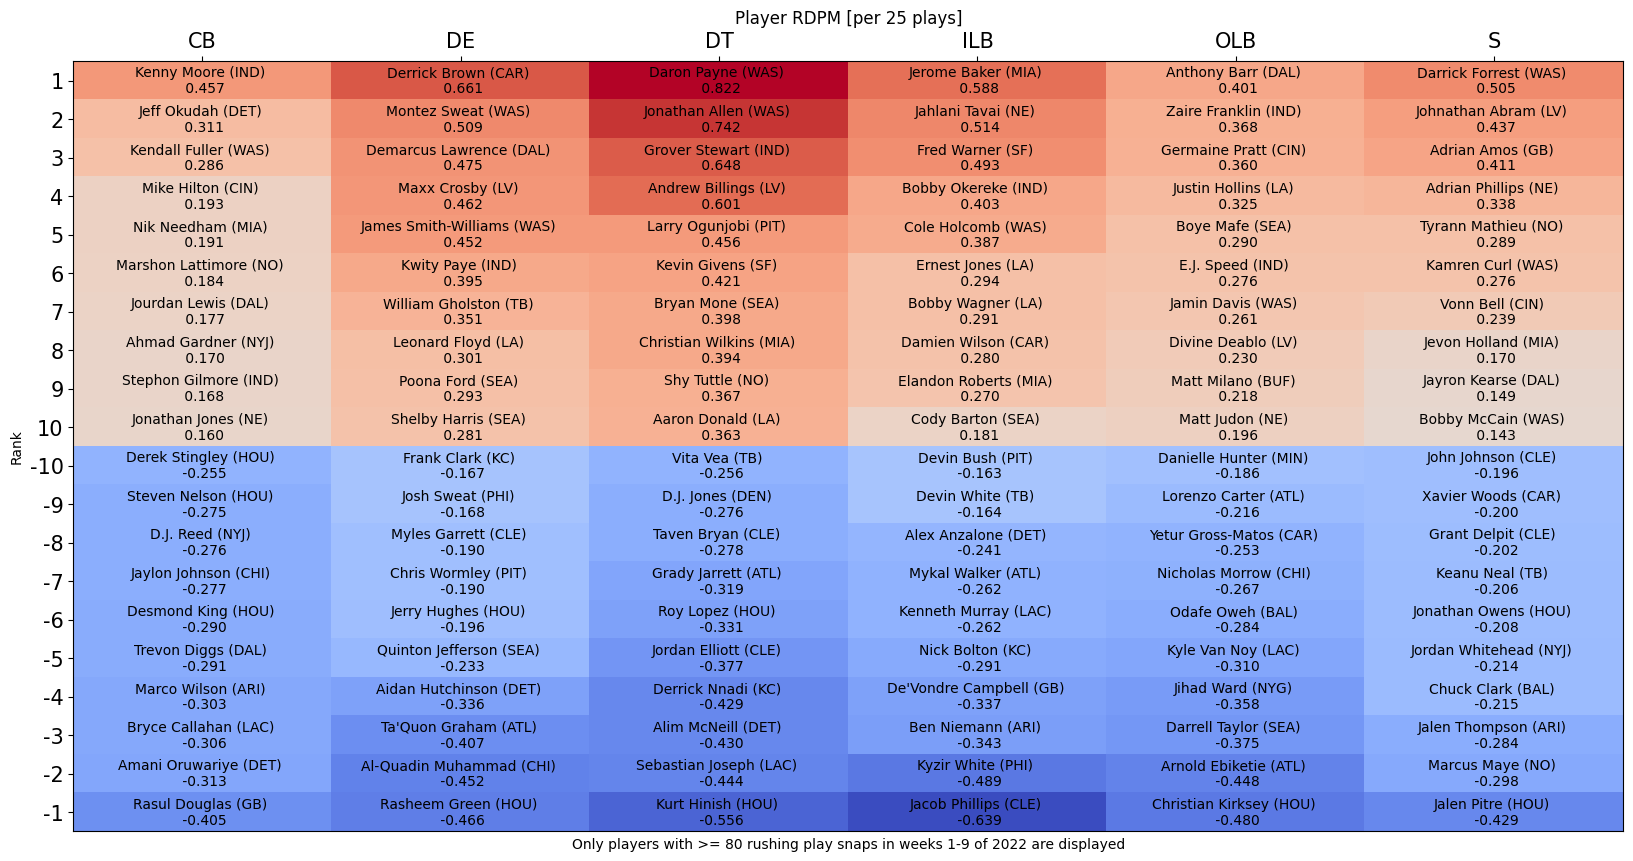

In [44]:
# Table for top-10 and bottom-10 RDPM players
fig, ax = plt.subplots(figsize=(20,10.))

plt.imshow(25.*tab_D_value.values.T, aspect='auto', cmap="coolwarm")

for (i,j), name in np.ndenumerate(tab_D_name.values):
    plt.text(i, j, f'{name} ({tab_D_team.values[i,j]}) \n {25.*tab_D_value.values[i,j]:.3f}', va='center', ha='center')

ax.xaxis.tick_top()
plt.xticks(ticks=range(len(tab_D_value)), labels=tab_D_value.index.values)
plt.yticks(ticks=range(len(tab_D_value.columns)), labels=[i for i in range(1,11,1)]+[i for i in range(-10,0)])
ax.tick_params(axis='both', which='major', labelsize=15)

plt.title('Player RDPM [per 25 plays]')
plt.xlabel('Only players with >= 80 rushing play snaps in weeks 1-9 of 2022 are displayed')
plt.ylabel('Rank')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/RDPM_table.png', bbox_inches='tight')

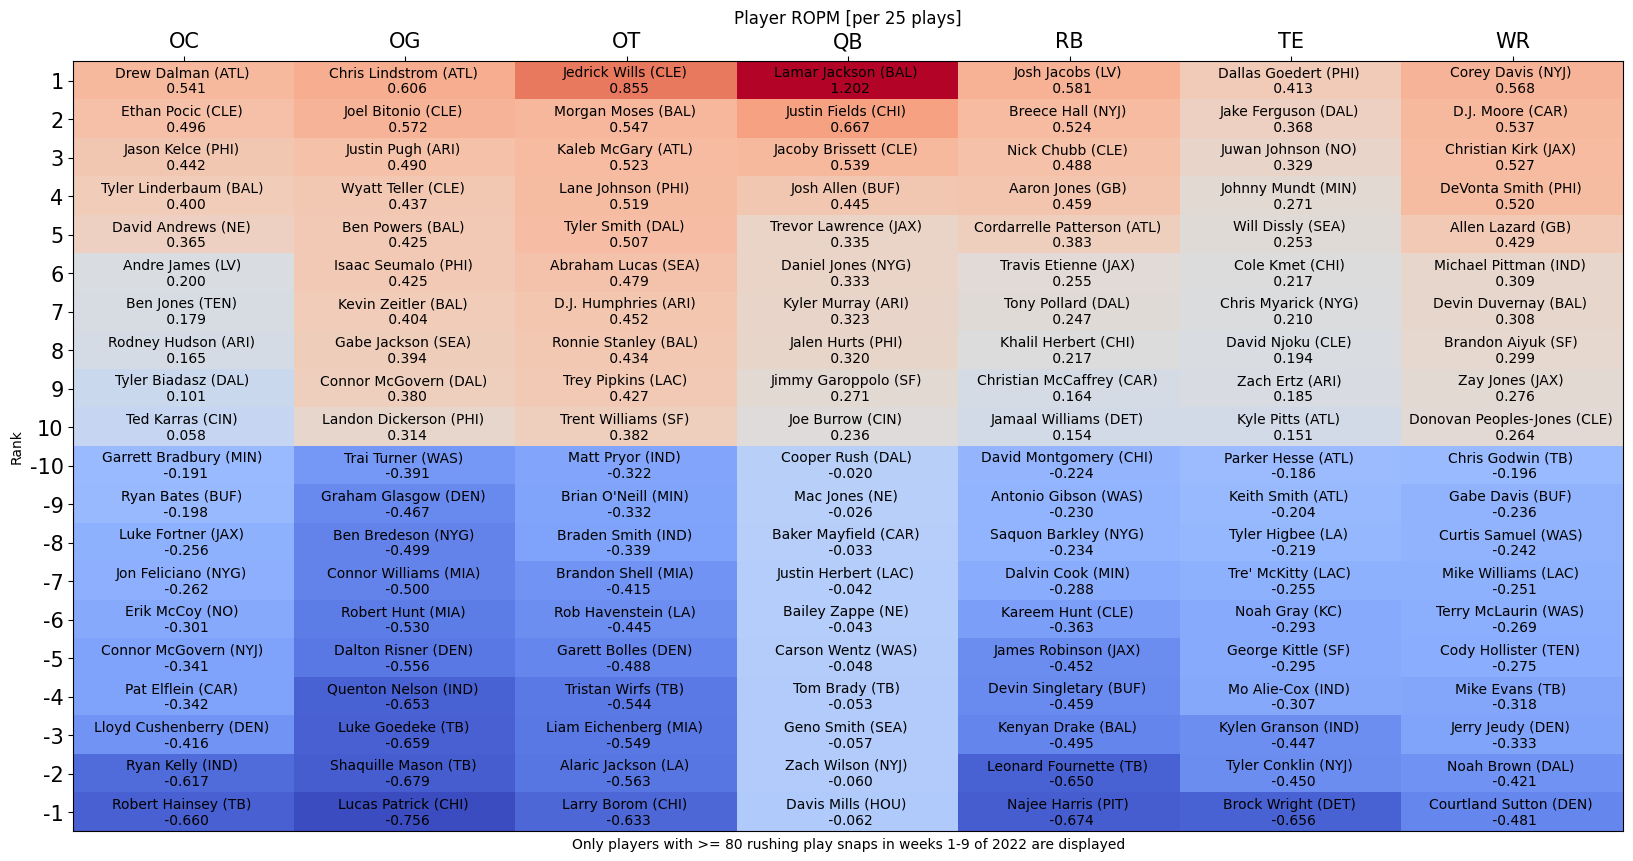

In [45]:
# Table for top-10 and bottom-10 ROPM players
fig, ax = plt.subplots(figsize=(20,10.))

plt.imshow(25.*tab_O_value.values.T, aspect='auto', cmap="coolwarm")

for (i,j), name in np.ndenumerate(tab_O_name.values):
    plt.text(i, j, f'{name} ({tab_O_team.values[i,j]}) \n {25.*tab_O_value.values[i,j]:.3f}', va='center', ha='center')

ax.xaxis.tick_top()
plt.xticks(ticks=range(len(tab_O_value)), labels=tab_O_value.index.values)
plt.yticks(ticks=range(len(tab_O_value.columns)), labels=[i for i in range(1,11,1)]+[i for i in range(-10,0)])
ax.tick_params(axis='both', which='major', labelsize=15)

plt.title('Player ROPM [per 25 plays]')
plt.xlabel('Only players with >= 80 rushing play snaps in weeks 1-9 of 2022 are displayed')
plt.ylabel('Rank')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/ROPM_table.png', bbox_inches='tight')

In [46]:
# Color schemes for each team

###
team_colors = {
 'ARI': 'tab:red',
 'ATL': 'tab:red',
 'BAL': 'tab:purple',
 'BUF': 'tab:blue',
 'CAR': 'tab:blue',
 'CHI': 'tab:orange',
 'CIN': 'tab:orange',
 'CLE': 'tab:brown',
 'DAL': 'tab:gray',
 'DEN': 'tab:orange',
 'DET': 'tab:cyan',
 'GB': 'tab:green',
 'HOU': 'tab:red',
 'IND': 'tab:blue',
 'JAX': 'tab:olive',
 'KC': 'tab:red',
 'LA': 'tab:blue',
 'LAC': 'tab:cyan',
 'LV': 'tab:gray',
 'MIA': 'tab:cyan',
 'MIN': 'tab:purple',
 'NE': 'tab:blue',
 'NO': 'tab:olive',
 'NYG': 'tab:blue',
 'NYJ': 'tab:green',
 'PHI': 'tab:green',
 'PIT': 'tab:olive',
 'SEA': 'tab:blue',
 'SF': 'tab:red',
 'TB': 'tab:red',
 'TEN': 'tab:blue',
 'WAS': 'tab:red'
}

###
team_colors_alt = {
 'ARI': 'darkred',
 'ATL': 'darkred',
 'BAL': 'darkviolet',
 'BUF': 'darkblue',
 'CAR': 'darkturquoise',
 'CHI': 'darkorange',
 'CIN': 'darkorange',
 'CLE': 'darkorange',
 'DAL': 'darkslategray',
 'DEN': 'darkorange',
 'DET': 'darkturquoise',
 'GB': 'darkgreen',
 'HOU': 'darkred',
 'IND': 'darkblue',
 'JAX': 'darkolivegreen',
 'KC': 'darkred',
 'LA': 'darkblue',
 'LAC': 'darkturquoise',
 'LV': 'darkslategray',
 'MIA': 'darkturquoise',
 'MIN': 'darkviolet',
 'NE': 'darkblue',
 'NO': 'darkolivegreen',
 'NYG': 'darkblue',
 'NYJ': 'darkgreen',
 'PHI': 'darkgreen',
 'PIT': 'darkolivegreen',
 'SEA': 'darkblue',
 'SF': 'darkred',
 'TB': 'darkred',
 'TEN': 'darkblue',
 'WAS': 'darkred'
}

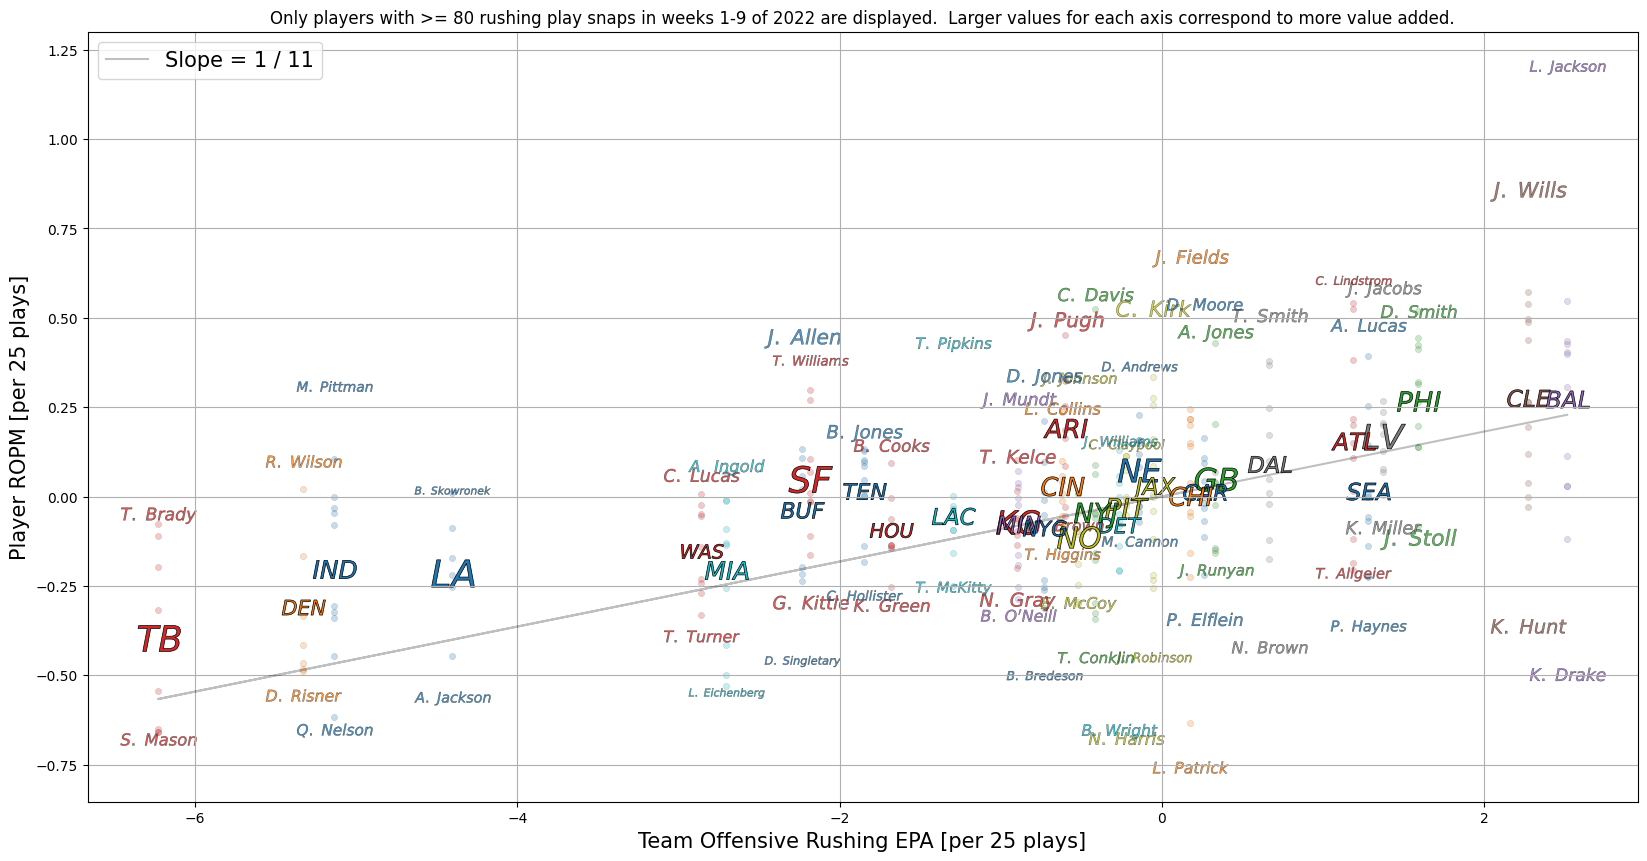

In [47]:
# Static chart of ROPM values for each team
fig, ax = plt.subplots(figsize=(20,10.))

x = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamEPA'].values
y = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['RYPM'].values
m = idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['displayName'].values
mins = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamMinRYPM'].values
means = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamMeanRYPM'].values
maxes = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamMaxRYPM'].values
c = idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamName'].values

for i in range(len(x)):
    flag1 = y[i] >= maxes[i]
    flag2 = y[i] <= mins[i]
    flag = flag1 or flag2
    plt.scatter(x[i], y[i], s=3000 if flag else 20, marker=f'${m[i].split()[0][0]}. \ {m[i].split()[-1]}$' if flag else 'o', color=team_colors[c[i]], alpha=0.75 if flag else 0.25, edgecolors='k', linewidths=0.25)
    
    if flag1:
        plt.scatter(x[i], means[i], s=1000, marker=f'${c[i]}$', color=team_colors[c[i]], edgecolors='k', linewidths=0.5)
        
plt.plot(x, x/11., 'k-', alpha=0.25, label='Slope = 1 / 11')

plt.xlabel('Team Offensive Rushing EPA [per 25 plays]')
plt.ylabel('Player ROPM [per 25 plays]')
plt.title('Only players with >= 80 rushing play snaps in weeks 1-9 of 2022 are displayed.  Larger values for each axis correspond to more value added.')

plt.legend(loc='upper left', prop={'size': 15})

ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

plt.grid(which='both')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/ROPM_chart.png', bbox_inches='tight')

In [48]:
# Interactive chart of ROPM values for each team

###
fig = go.Figure()

###
x = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamEPA'].values
y = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['RYPM'].values
m = np.array([ f'{a} ({b})' for a,b in zip(idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['displayName'].values, idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamName'].values) ])
c = np.array([ team_colors_alt[a] for a in idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamName'].values ])
t = idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamName'].values
means = 25.*idk[(idk['side'] == 'O') & (idk['snaps'] >= 80)]['teamMeanRYPM'].values

dfp = pd.DataFrame({'x': x,
                   'y': y,
                   'm': m,
                   'c': c,
                   't': t,
                   'ymean': means})

fig.add_trace(go.Scatter( 
    x=dfp['x'],
    y=dfp['y'],
    mode='markers',
    text=dfp['m'],
    name='Players',
    
    marker=dict(
        size=7.5,
        color=dfp['c'],
        opacity=0.25,
        line=dict(width=0.5, color='black')
    ),
))

###
dft = dfp[['x','c','t','ymean']].drop_duplicates()


fig.add_trace(go.Scatter( 
    x=dft['x'],
    y=dft['ymean'],
    mode='text',
    text=dft['t'],
    textposition="middle center",
    name='Teams',
    
    textfont=dict(
        color=dft['c'],
        size=15,
    ),
))

###
fig.add_trace(go.Scatter( 
    x=np.array([dfp['x'].min(),dfp['x'].max()]),
    y=np.array([dfp['x'].min(),dfp['x'].max()]) / 11.,
    mode='lines',
    opacity=0.25,
    name='Slope = 1 / 11',
    
    line=dict(
        width=0.5,
        color='black',
    ),
))

###
fig.update_layout(
    title='<sup>Plot is interactive: hover for player names, select area to zoom in, double-click to zoom out, click on legend to (un)hide items.<br>Only players with >= 80 rushing play snaps in weeks 1-9 of 2022 are displayed.<br>Larger values for each axis correspond to more value added.</sup>',
    xaxis_title='Team Offensive Rushing EPA [per 25 plays]',
    yaxis_title='Player ROPM [per 25 plays]',
    width=1025,
    height=500,
)


fig.write_html('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/ROPM_chart.html', auto_open=True)

In [49]:
%%html
<iframe 
    src="figures/ROPM_chart.html" 
    width="1050" 
    height="525" 
    title="ROPM_chart" 
    style="border:none">
</iframe>

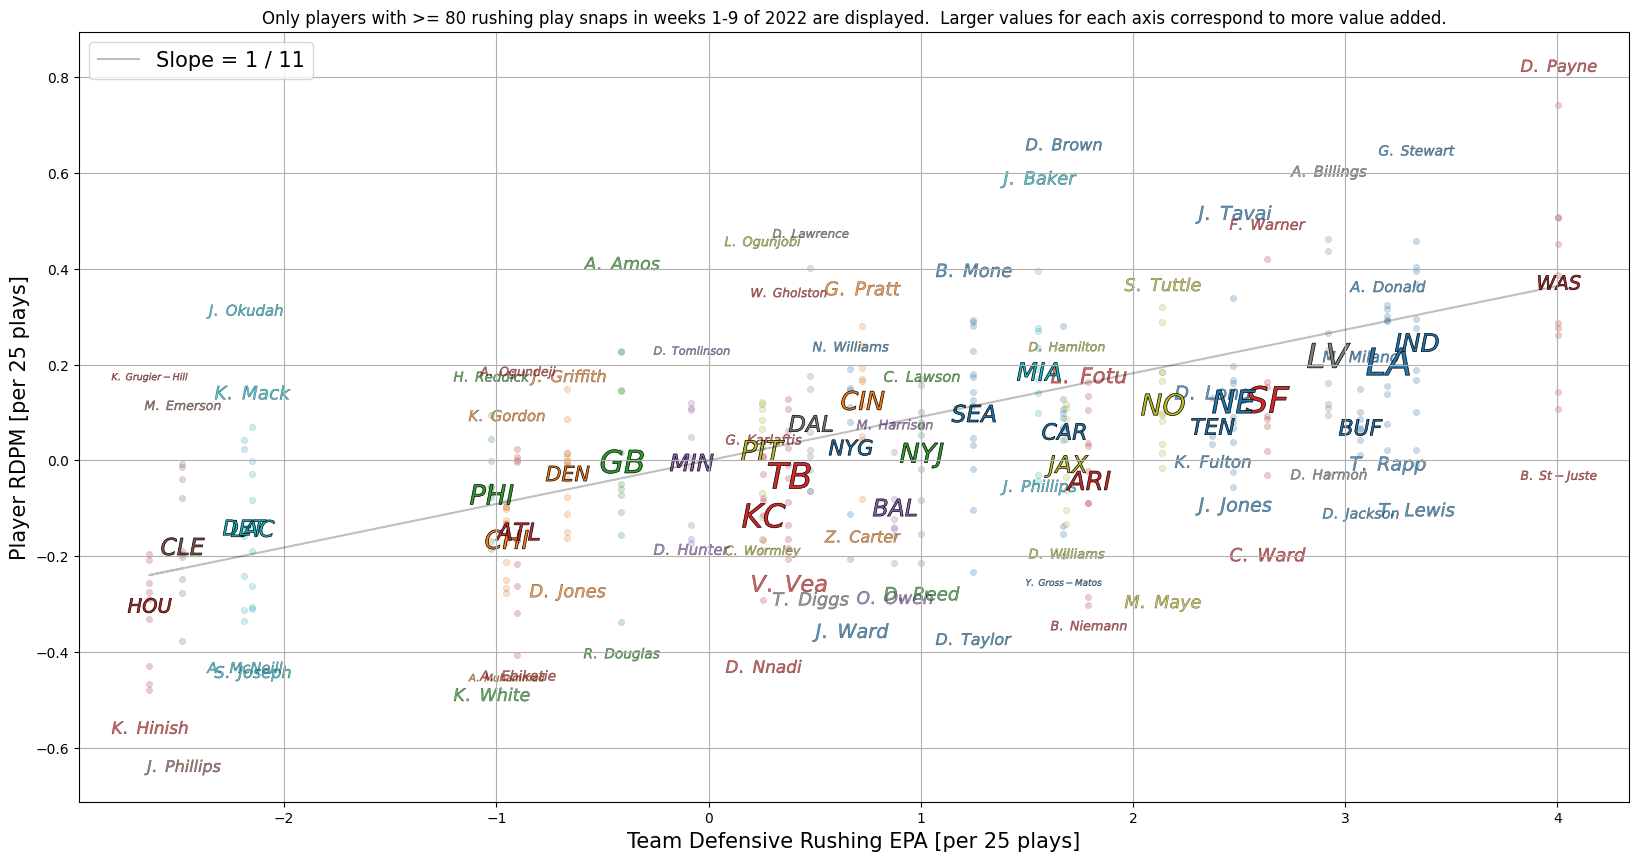

In [50]:
# Static chart of RDPM values for each team
fig, ax = plt.subplots(figsize=(20,10.))

x = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamEPA'].values
y = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['RYPM'].values
m = idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['displayName'].values
mins = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamMinRYPM'].values
means = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamMeanRYPM'].values
maxes = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamMaxRYPM'].values
c = idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamName'].values

for i in range(len(x)):
    flag1 = y[i] >= maxes[i]
    flag2 = y[i] <= mins[i]
    flag = flag1 or flag2
    plt.scatter(x[i], y[i], s=3000 if flag else 20, marker=f'${m[i].split()[0][0]}. \ {m[i].split()[-1]}$' if flag else 'o', color=team_colors[c[i]], alpha=0.75 if flag else 0.25, edgecolors='k', linewidths=0.25)
    
    if flag1:
        plt.scatter(x[i], means[i], s=1000, marker=f'${c[i]}$', color=team_colors[c[i]], edgecolors='k', linewidths=0.5)

plt.plot(x, x/11., 'k-', alpha=0.25, label='Slope = 1 / 11')

plt.xlabel('Team Defensive Rushing EPA [per 25 plays]')
plt.ylabel('Player RDPM [per 25 plays]')
plt.title('Only players with >= 80 rushing play snaps in weeks 1-9 of 2022 are displayed.  Larger values for each axis correspond to more value added.')

plt.legend(loc='upper left', prop={'size': 15})

ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

plt.grid(which='both')

plt.savefig('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/RDPM_chart.png', bbox_inches='tight')

In [51]:
# Interactive chart of RDPM values for each team

###
fig = go.Figure()

###
x = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamEPA'].values
y = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['RYPM'].values
m = np.array([ f'{a} ({b})' for a,b in zip(idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['displayName'].values, idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamName'].values) ])
c = np.array([ team_colors_alt[a] for a in idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamName'].values ])
t = idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamName'].values
means = 25.*idk[(idk['side'] == 'D') & (idk['snaps'] >= 80)]['teamMeanRYPM'].values

dfp = pd.DataFrame({'x': x,
                   'y': y,
                   'm': m,
                   'c': c,
                   't': t,
                   'ymean': means})

fig.add_trace(go.Scatter( 
    x=dfp['x'],
    y=dfp['y'],
    mode='markers',
    text=dfp['m'],
    name='Players',
    
    marker=dict(
        size=7.5,
        color=dfp['c'],
        opacity=0.25,
        line=dict(width=0.5, color='black')
    ),
))

###
dft = dfp[['x','c','t','ymean']].drop_duplicates()


fig.add_trace(go.Scatter( 
    x=dft['x'],
    y=dft['ymean'],
    mode='text',
    text=dft['t'],
    textposition="middle center",
    name='Teams',
    
    textfont=dict(
        color=dft['c'],
        size=15,
    ),
))

###
fig.add_trace(go.Scatter( 
    x=np.array([dfp['x'].min(),dfp['x'].max()]),
    y=np.array([dfp['x'].min(),dfp['x'].max()]) / 11.,
    mode='lines',
    opacity=0.25,
    name='Slope = 1 / 11',
    
    line=dict(
        width=0.5,
        color='black',
    ),
))

###
fig.update_layout(
    title='<sup>Plot is interactive: hover for player names, select area to zoom in, double-click to zoom out, click on legend to (un)hide items.<br>Only players with >= 80 rushing play snaps in weeks 1-9 of 2022 are displayed.<br>Larger values for each axis correspond to more value added.</sup>',
    xaxis_title='Team Defensive Rushing EPA [per 25 plays]',
    yaxis_title='Player RDPM [per 25 plays]',
    width=1025,
    height=500,
)


fig.write_html('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/RDPM_chart.html', auto_open=True)

In [52]:
%%html
<iframe 
    src="figures/RDPM_chart.html" 
    width="1050" 
    height="525" 
    title="RDPM_chart" 
    style="border:none">
</iframe>

## 5. Example Play: WAS vs IND  <a class="anchor" id="example"></a>

In [53]:
# Show top predicted EPA plays for WAS
pred_df = y_epa.to_frame()
pred_df['predEPA'] = reg.predict(x_id_dic[max_params[0]].values)
pred_df['possessionTeam'] = plays_df['possessionTeam']
pred_df['defensiveTeam'] = plays_df['defensiveTeam']
pred_df['prePenaltyPlayResult'] = plays_df['prePenaltyPlayResult']
pred_df['yardlineSide'] = plays_df['yardlineSide']
pred_df['yardlineNumber'] = plays_df['yardlineNumber']
pred_df['quarter'] = plays_df['quarter']
pred_df['down'] = plays_df['down']
pred_df['yardsToGo'] = plays_df['yardsToGo']
pred_df['playDescription'] = plays_df['playDescription']

pred_df[ pred_df['defensiveTeam'] == 'WAS' ].sort_values('predEPA').head() #.iloc[0] #['playDescription']

EPA   predEPA possessionTeam defensiveTeam  \
gameId     playId                                                    
2022103009 2571   -2.713819 -0.238145            IND           WAS   
           3146   -0.261669 -0.221620            IND           WAS   
           1869    1.191933 -0.215043            IND           WAS   
           3125   -0.476197 -0.208661            IND           WAS   
           1848   -0.720642 -0.208420            IND           WAS   

                   prePenaltyPlayResult yardlineSide  yardlineNumber  quarter  \
gameId     playId                                                               
2022103009 2571                      -1          WAS               1        4   
           3146                       3          IND              27        4   
           1869                       3          WAS              42        3   
           3125                       2          IND              25        4   
           1848                       1          WAS              43        3   

                   down  yardsToGo  \
gameId     playId                    
2022103009 2571       3          1   
           3146       2          8   
           1869       3          2   
           3125       1         10   
           1848       2          3   

                                                     playDescription  
gameId     playId                                                     
2022103009 2571    (13:18) (Shotgun) J.Taylor up the middle to WA...  
           3146    (4:16) (Shotgun) J.Taylor up the middle to IND...  
           1869    (11:10) (Shotgun) S.Ehlinger right end pushed ...  
           3125    (4:55) (Shotgun) J.Taylor up the middle to IND...  
           1848    (11:42) (Shotgun) J.Taylor right tackle to WAS...

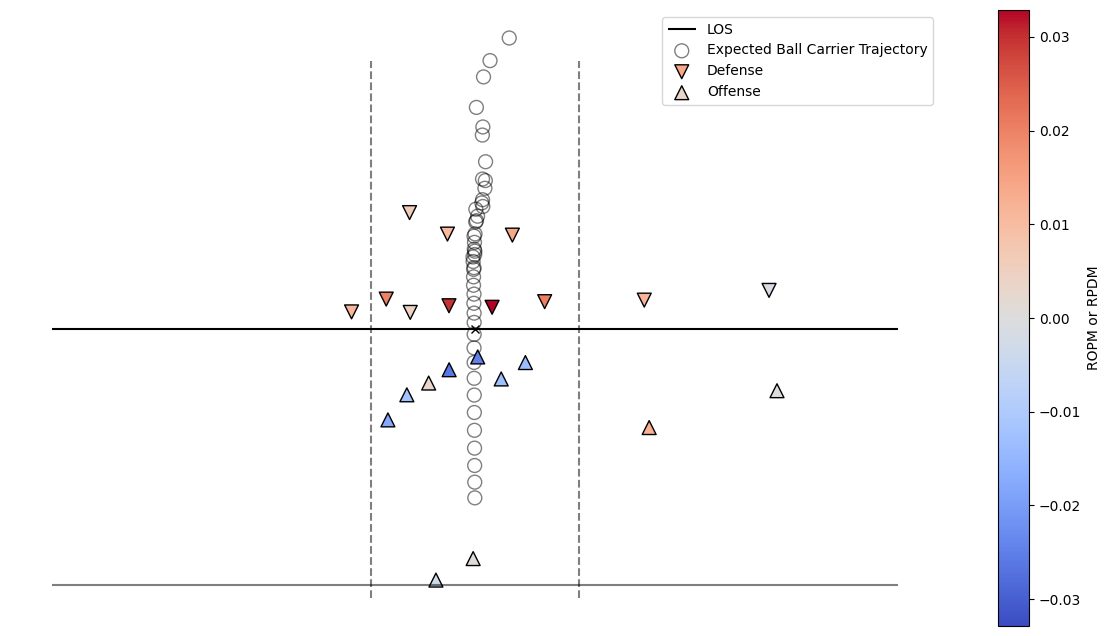

In [54]:
# Static plot of ROPM/RDPM and expected trajectory for example play

###
rypms = pd.DataFrame.from_dict({a:b for a,b in zip(x_id_dic[max_params[0]].columns,reg.coef_) }, orient='index', columns=['RYPM'])
rypms.index = rypms.index.rename('nflId')

eg_O = fit_df[ (fit_df['gameId'] == 2022103009) & (fit_df['playId'] == 2571) & (fit_df['side'] == 'O') ]
eg_D = fit_df[ (fit_df['gameId'] == 2022103009) & (fit_df['playId'] == 2571) & (fit_df['side'] == 'D') ]

eg_O.loc[ (eg_O['position'].isin(['QB','RB'])), 'exposure0d33' ] = 0.
eg_O.loc[ eg_O['isBallCarrier'], 'exposure0d33' ] = 1.

eg_O = eg_O.set_index('nflId').sort_index(level=[0],ascending=[True])
eg_O['RYPM'] = rypms
eg_O['predEPA'] = eg_O['exposure0d33']*eg_O['RYPM']

eg_D = eg_D.set_index('nflId').sort_index(level=[0],ascending=[True])
eg_D['RYPM'] = rypms
eg_D['predEPA'] = -1*eg_D['exposure0d33']*eg_D['RYPM']

###
plt.figure(figsize=(15,8.))

plt.plot([0.], [0.], 'kx')

plt.hlines(-5., -25, 25, 'k', linestyle='solid', alpha=0.5)
plt.hlines(0., -25, 25, 'k', linestyle='solid', alpha=1.0, label='LOS')

plt.vlines(-6.167, -5.25, 5.25, 'k', linestyle='dashed', alpha=0.5)
plt.vlines(6.167, -5.25, 5.25, 'k', linestyle='dashed', alpha=0.5)

for i in set(eg_O['runType']):
    tmp = rc_df.loc[i]
    plt.scatter(tmp['y'].values, tmp['x'].values, s=100, facecolors='none', edgecolors='k', alpha=0.5, label='Expected Ball Carrier Trajectory')

vmax = max(eg_O['RYPM'].abs().max(), eg_D['RYPM'].abs().max())
vmin = -vmax

plt.scatter(eg_D['y'], eg_D['x'], c=eg_D['RYPM'], marker='v', s=100, cmap='coolwarm', edgecolors='k', vmin=vmin, vmax=vmax, label='Defense')
plt.scatter(eg_O['y'], eg_O['x'], c=eg_O['RYPM'], marker='^', s=100, cmap='coolwarm', edgecolors='k', vmin=vmin, vmax=vmax, label='Offense')

cb2 = plt.colorbar()
cb2.set_label('ROPM or RPDM')

plt.xlabel('y')
plt.ylabel('x')

plt.axis('off')

plt.legend()

In [55]:
# Generate gif showing ROPM and RDPM, expected trajectories, and actual trajectories for example play

###
rc('animation', html='html5')

###
def Plotter(iframe, df, lines, possessionTeam, defensiveTeam, buffer):
    # How to update gif frames
    if iframe < buffer:
        return lines
    
    tmp = df.loc[iframe+1-buffer]

    if len(set(tmp['event'])) > 1:
        print(set(tmp['event']))

    inds_D = tmp['club'] == defensiveTeam
    x_D = tmp[ inds_D ]['x'].values
    y_D = 53.3 - tmp[ inds_D ]['y'].values
    j_D = tmp[ inds_D ]['jerseyNumber'].values
    
    inds_O = tmp['club'] == possessionTeam
    x_O = tmp[ inds_O ]['x'].values
    y_O = 53.3 - tmp[ inds_O ]['y'].values
    j_O = tmp[ inds_O ]['jerseyNumber'].values

    inds_B = tmp['club'] == 'football' 
    x_B = tmp[ inds_B ]['x'].values
    y_B = 53.3 - tmp[ inds_B ]['y'].values
 
    x_P = tmp.loc[46082.0]['x']
    y_P = 53.3 - tmp.loc[46082.0]['y']

    lines[0].set_offsets([ [y,x] for y,x in zip(y_D,x_D)])
    lines[1].set_offsets([ [y,x] for y,x in zip(y_O,x_O)])
    
    for i in range(11):
        ###
        lines[i+2].set_offsets([y_D[i], x_D[i]])
    
    for i in range(11):
        ###
        lines[i+2+11].set_offsets([y_O[i], x_O[i]])
    
    lines[-2].set_offsets([y_B[0], x_B[0]])
    lines[-1].set_offsets([y_P, x_P])
        
    return lines[:-1]

###
def AnimatePlay(speed=0.5, scale=3., buffer=25):
    ### Construct gif ###
    
    #Get tracking data
    df = tracking_df.loc[ (2022103009,2571) ]

    possessionTeam = plays_df.loc[ (2022103009,2571) ]['possessionTeam']
    defensiveTeam = plays_df.loc[ (2022103009,2571) ]['defensiveTeam']
    
    n_frames = len(set(df.index)) + buffer

    ###
    rypms = pd.DataFrame.from_dict({a:b for a,b in zip(x_id_dic[max_params[0]].columns,reg.coef_) }, orient='index', columns=['RYPM'])
    rypms.index = rypms.index.rename('nflId')

    df = df.reset_index().set_index('nflId').sort_index(level=[0],ascending=[True])
    df['RYPM'] = rypms
    df = df.reset_index().set_index(['frameId','nflId']).sort_index(level=[0,1],ascending=[True,True])
    
    #Set up figure
    fig = plt.figure()
    fig.set_size_inches(scale*(53.3/15.), scale)
    ax1 = plt.axes(xlim=(0, 53.3), ylim=(0,120))
    plt.yticks([(i+1)*10 for i in range(11)], [min(i*10, 100-i*10) for i in range(11)])
    plt.xticks([],[])
    
    _ = ax1.vlines(23.5833, 10, 110, 'k', linestyle='dotted', alpha=0.5)
    _ = ax1.vlines(29.7500, 10, 110, 'k', linestyle='dotted', alpha=0.5)
    for i in range(11):
        _ = ax1.hlines((i+1)*10, 0, 53.3, 'k', linestyle='solid', alpha=0.5)
    for i in range(10):
        _ = ax1.hlines(5+(i+1)*10, 0, 53.3, 'k', linestyle='solid', alpha=0.25)

    for i,m,l in zip([6,4],['o','x'],['M','R3']):
        tmp = rc_df.loc[i]
        plt.scatter(tmp['y'].values + 53.3/2. - (29.7500-23.5833)/2., 109.+tmp['x'].values, color='black', marker=m, s=scale*5, alpha=0.2, label=l)
    
    vmax = df['RYPM'].abs().max()
    vmin = -vmax
    
    lines = []

    df_D = df[ (df.index.get_level_values(0) == 1) & (df['club'] == defensiveTeam) ]
    lines += [ ax1.scatter(53.3-df_D['y'], df_D['x'], c=df_D['RYPM'], marker='v', s=scale*50, cmap='coolwarm', edgecolors='none', vmin=vmin, vmax=vmax, label='WAS (Defense)') ]
    
    df_O = df[ (df.index.get_level_values(0) == 1) & (df['club'] == possessionTeam) ]
    lines += [ ax1.scatter(53.3-df_O['y'], df_O['x'], c=df_O['RYPM'], marker='^', s=scale*50, cmap='coolwarm', edgecolors='none', vmin=vmin, vmax=vmax, label='IND (Offense)') ]
    
    for i in range(11):
        lines += [ ax1.scatter([53.3-df_D['y'].iloc[i]],[df_D['x'].iloc[i]], marker=f"${int(df_D['jerseyNumber'].iloc[i])}$", color='black', s=scale*33, alpha=1., linewidths=1) ]

    for i in range(11):
        lines += [ ax1.scatter([53.3-df_O['y'].iloc[i]],[df_O['x'].iloc[i]], marker=f"${int(df_O['jerseyNumber'].iloc[i])}$", color='black', s=scale*33, alpha=1., linewidths=1) ]
    
    t = MarkerStyle(marker='d')
    lines += [ ax1.scatter([],[], color='brown', marker=t, s=scale*15) ]
    
    df_P = df.loc[ (1,46082.0) ]
    lines += [ ax1.scatter(53.3-df_P['y'], df_P['x'], marker='o', s=scale*150, alpha=1., facecolors='none', edgecolors='yellow', label='Daron Payne (WAS)') ]

    _ = ax1.set_ylim(100,115)

    cb2 = plt.colorbar(lines[0])
    cb2.set_label('ROPM or RPDM [per play]')

    plt.legend(loc='upper left')

    plt.title('WAS 7-6 IND, Q4 13:18, 3rd & 1 from WAS 1')
    plt.xlabel('Predicted EPA for M = -0.24, Predicted EPA for R3 = -0.04, Realized EPA = -2.7')
    
    #Create animation
    anim = animation.FuncAnimation(fig, Plotter, fargs=(df, lines, possessionTeam, defensiveTeam, buffer), frames=n_frames, interval=75/speed, blit=True)
    
    plt.close()
    return anim

In [56]:
# Generate gif
ani = AnimatePlay()

# Save gif
writer = animation.PillowWriter(fps=1000./150.,
                                 metadata=dict(artist='Ryan Lynch'),
                                 bitrate=1800)
ani.save('/home/ryanl/Projects/nfl_big_data_bowl_2024/figures/Daron_Payne.gif', writer=writer)

#Show gif
ani

In [57]:
plays_df.loc[(2022103009,2571)]

ballCarrierId                                                                   52449
ballCarrierDisplayName                                                Jonathan Taylor
playDescription                     (13:18) (Shotgun) J.Taylor up the middle to WA...
quarter                                                                             4
down                                                                                3
yardsToGo                                                                           1
possessionTeam                                                                    IND
defensiveTeam                                                                     WAS
yardlineSide                                                                      WAS
yardlineNumber                                                                      1
gameClock                                                                       13:18
preSnapHomeScore                                      

Daron Payne
130
-0.2626226482153846


<Axes: >

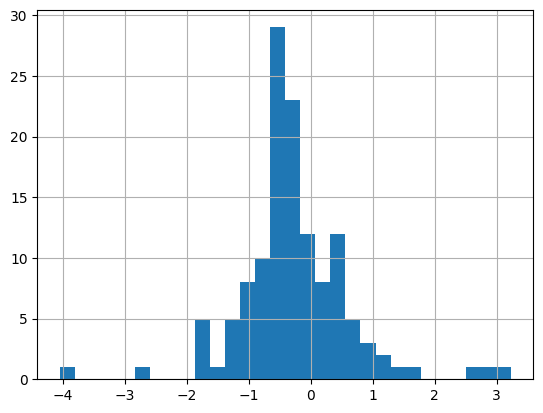

In [58]:
# Daron Payne: plays with exposure > 0.5
print(fit_df[ (fit_df['nflId'] == 46082.0) ]['displayName'].head(1).values[0])
print(fit_df[ (fit_df['nflId'] == 46082.0) & (fit_df['exposure0d33'] > 0.5) ]['EPA'].count())
print(fit_df[ (fit_df['nflId'] == 46082.0) & (fit_df['exposure0d33'] > 0.5) ]['EPA'].mean())
fit_df[ (fit_df['nflId'] == 46082.0) & (fit_df['exposure0d33'] > 0.5) ]['EPA'].hist(bins=30)

Daron Payne
37
0.09168657070270272


<Axes: >

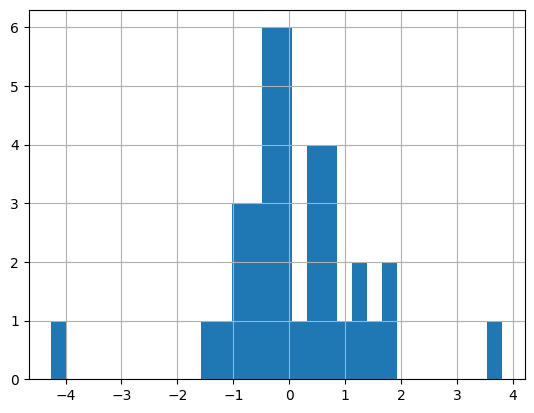

In [59]:
# Daron Payne: plays with exposure < 0.5
print(fit_df[ (fit_df['nflId'] == 46082.0) ]['displayName'].head(1).values[0])
print(fit_df[ (fit_df['nflId'] == 46082.0) & (fit_df['exposure0d33'] < 0.5) ]['EPA'].count())
print(fit_df[ (fit_df['nflId'] == 46082.0) & (fit_df['exposure0d33'] < 0.5) ]['EPA'].mean())
fit_df[ (fit_df['nflId'] == 46082.0) & (fit_df['exposure0d33'] < 0.5) ]['EPA'].hist(bins=30)

In [60]:
### Construct df to make EPA predictions for the example play for each rushing class

# Copy base plays data
alt_plays_df = pd.DataFrame(np.repeat(plays_df.loc[[(2022103009,2571)]].reset_index().values, 7, axis=0))
alt_plays_df.columns = plays_df.reset_index().columns
alt_plays_df = alt_plays_df.set_index(['gameId','playId'])

# Vary run type and find distances
alt_plays_df['runType'] = np.arange(7)
alt_fit_df = CalculateDistanceSnapToExpectedBallCarrier(alt_plays_df, tracking_df, rc_df)

# Add player positions
alt_fit_df = alt_fit_df.set_index(['nflId']).sort_index(level=[0],ascending=[True]).join(players_df[['position','displayName']])
alt_fit_df['position'] = alt_fit_df['position'].apply(lambda x: position_conversion_dic[x])

# Add player max speeds
max_speeds = tracking_df.groupby(['gameId','playId','nflId'])['s'].max().groupby('nflId').quantile(0.99)
max_speeds.name = 'maxSpeed'
alt_fit_df = alt_fit_df.join(max_speeds)

alt_fit_df = alt_fit_df.reset_index().set_index(['position']).sort_index(level=[0],ascending=[True])
alt_fit_df['maxSpeed'] = alt_fit_df['maxSpeed'].mean()

alt_fit_df = alt_fit_df.reset_index()

# Add coverage
alt_fit_df = alt_fit_df.set_index(['gameId','playId']).sort_index(level=[0,1],ascending=[True,True])

alt_fit_df['exposure0d33'] = [ np.sum((a <= (0.33*b))*w) / np.sum(w) for a,b,w in zip(alt_fit_df['speedsNeededToReach'].values,alt_fit_df['maxSpeed'].values,alt_fit_df['weights'].values) ]

alt_fit_df = alt_fit_df.reset_index()

# Add ROPM and RDPM
rypms = pd.DataFrame.from_dict({a:b for a,b in zip(x_id_dic[max_params[0]].columns,reg.coef_) }, orient='index', columns=['RYPM'])
rypms.index = rypms.index.rename('nflId')

alt_fit_df = alt_fit_df.set_index('nflId').sort_index(level=[0],ascending=[True])
alt_fit_df['RYPM'] = rypms
alt_fit_df = alt_fit_df.reset_index()

alt_fit_df.loc[ alt_fit_df['position'].isin(['QB','RB']), 'exposure0d33' ] = 0
alt_fit_df.loc[ alt_fit_df['isBallCarrier'], 'exposure0d33' ] = 1
alt_fit_df.loc[ alt_fit_df['side'] == 'D', 'exposure0d33' ] *= -1.

In [61]:
# Calculate predicted EPA for example play for each rushing class
alt_fit_df.groupby('runType').apply(lambda x: x['RYPM'].values @ x['exposure0d33'].values + reg.intercept_)

runType
0   -0.057739
1   -0.182978
2   -0.243391
3   -0.212819
4   -0.035282
5   -0.230521
6   -0.238145
dtype: float64